<a href="https://colab.research.google.com/github/RobJavVar/SG_GeometryBasedBeliefsAndDecisions/blob/main/notebooks/GeoBasedDecisions_AnalysisPipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Media Consumption and Identity based Concept Geometries Predict Engagement and Beliefs Towards Societal Institutions
<b>Active project: [OSF Link](https://osf.io/vj7e5/)</b><br><br>
Authors: <b>Dr. Roberto Vargas; Ash Gelber; Dr. Timothy Verstynen </b><br>
Codebook created by: <b>Roberto Vargas </b><br>
<br>
<b>Pipeline includes:</b><br> [this is out of date]
*   Data restructuring: Sorting accoring to word list
*   Replication of previous work:
 *  Regression predicting pair edged using: <i>Race; Gender; Income; Age; NewsBias</i>
 *   Mediation analysis
*    Edge-wise predictions of agreement: <i>mantel's boostrapping; permutation testing</i>

<br>
<br>

### **ToDo:**

*   For H2: Use an alternative model fit metric for the logistic model: [use Precision, Recall, F1, AOC, confusions]

*   For H3 analysis: compute permutation test within each cross-validation fold (scramble Y) do 10k
*   Balance groups to reflect sample proportions. Half MF/BW; 2-1 LR 
*   Generate descriptive proportions for all pairwise participants: LL RR LR | MM MW WW | BW WW BB average alignment across all items
*   Run full model on each item individually; using a logistic model. use Precision, Recall, F1, AOC, and confusions. | "pred and observed" | aggree or disagree -> base-rates = ((P(agree)_L*n_L) * (P(agree)_R*n_R))/(n_L+n_R)





### Comprehensive notebook for Geometry Based Decision project

#### Install dependancies

In [12]:
#@title Install dependancies
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import networkx as nx
import scipy
from scipy import stats
from scipy.stats import t
from scipy.stats import entropy
from scipy.stats import norm
from collections import Counter
import itertools
from itertools import combinations
from itertools import compress
import math
import statsmodels.formula.api as smf
import statsmodels as sm
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeavePOut
from sklearn.metrics import mean_squared_error
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, balanced_accuracy_score, matthews_corrcoef,
    roc_auc_score, average_precision_score, brier_score_loss, log_loss
)
import csv
from tqdm import tqdm
import requests
import os
import re
import warnings


# import geopandas as gpd
# !pip install census --quiet
# !pip install us --quiet
# from census import Census
# from us import states

#### Define utility functions

In [13]:
#@title Define utility functions
def weightedHeatmap(PairData, words, PlotHM, Title, cbarLab):
    '''
    Restructure RT into matrix data structure
    '''
    Wmat = np.zeros((len(words),len(words)))
    t = 0
    z = 0

    for i in range(len(words)):
        for j in range(len(words)):
            if i == j:
#                Wmat[i,j] = np.NaN
                Wmat[i,j] = 7
            elif j > i:
                Wmat[i,j] = PairData[t]
                Wmat[j,i] = PairData[t]
                t += 1

    if PlotHM == 1:
      ax = plt.gca()
      im = ax.imshow(Wmat, cmap = 'RdBu', vmin=-7, vmax=7)
      cbar = ax.figure.colorbar(im, ax = ax, shrink=0.7)
      cbar.ax.set_ylabel(cbarLab, rotation = -90, va = "bottom")
      ax.set_xticks(np.arange(Wmat.shape[1]), labels = words, size=15)
      ax.set_yticks(np.arange(Wmat.shape[0]), labels = words, size=15)
      ax.tick_params(top = True, bottom = False, labeltop = True, labelbottom = False)
      plt.setp(ax.get_xticklabels(), rotation = -45, ha = "right", rotation_mode = "anchor", size=15)
      #ax.spines[:].set_visible(False)
      ax.set_xticks(np.arange(Wmat.shape[1] + 1) - 0.5, minor = True)
      ax.set_yticks(np.arange(Wmat.shape[0] + 1) - 0.5, minor = True)
      ax.grid(which = "minor", color = "black", linestyle = '-', linewidth = 1)
      ax.tick_params(which =  "minor", bottom = False, left = False)
      ax.set_title(Title)
      plt.show()
    return Wmat

def confidence_interval(data, confidence=0.95):
    data = np.asarray(data)
    n = len(data)
    mean = np.mean(data)
    se = stats.sem(data)  # standard error
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return mean - h, mean + h

def wilson_ci(x, n, confidence=0.95):
    from scipy.stats import norm
    z = norm.ppf(1 - (1 - confidence)/2)
    p = x / n
    denom = 1 + z**2 / n
    center = (p + z**2 / (2 * n)) / denom
    margin = z * np.sqrt((p * (1 - p) + z**2 / (4 * n)) / n) / denom
    return max(0, center - margin), min(1, center + margin)

def item_randperm(size, perm):
    # Generate perm random permutations
    return np.array([np.random.permutation(size) for _ in range(perm)], dtype=int)

def splitHalf_Reliability(dat, perm):
    """
    Compute the reliability within a measure by splitting the data into two halves,
    averaging their similarity structures, and repeating the process over multiple permutations.
    """
    dat_array = dat.to_numpy()  # Convert DataFrame to NumPy array for efficiency
    n_items = dat_array.shape[1]

    pSplit = np.array([np.random.permutation(n_items) for _ in range(perm)])  # Generate all permutations at once

    half_size = n_items // 2  # Integer division ensures correct half-splitting
    rho = np.zeros(perm)  # Preallocate for performance

    for p in range(perm):
        split_indices = pSplit[p]

        # Split data
        frstHalf = dat_array[:, split_indices[:half_size]]
        scndHalf = dat_array[:, split_indices[half_size:]]

        # Compute means
        avgFrstHalf = frstHalf.mean(axis=1)
        avgScndHalf = scndHalf.mean(axis=1)

        # Compute correlation
        rho[p] = np.corrcoef(avgFrstHalf, avgScndHalf)[0, 1]

    return rho.mean()

def permLogisticRegression(X, Y, perm, class_weight=None):
    '''
    Perform logistic regression on observed and permuted data.
    Returns observed coefficients, p-values, permuted coefficients,
    observed accuracy, and permutation accuracies.

    Parameters:
    - X: Features (2D array or DataFrame)
    - Y: Binary labels (1D array)
    - perm: Number of permutations
    - class_weight: 'balanced' OR None
    '''
    # Convert to NumPy arrays
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()
    X = np.asarray(X, dtype=np.float64)
    Y = np.asarray(Y, dtype=np.int32)

    if X.ndim == 1:
        X = X.reshape(-1, 1)

    if X.shape[0] != Y.shape[0]:
        raise ValueError("Number of rows in X must match length of Y")

    n_samples = X.shape[0]
    pComb = np.array([np.random.permutation(n_samples) for _ in range(perm)])

    # Fit logistic regression to observed data
    model_obs = LogisticRegression(class_weight, solver='liblinear')
    model_obs.fit(X, Y)
    betaObs = np.concatenate(([model_obs.intercept_[0]], model_obs.coef_.flatten()))
    accObs = accuracy_score(Y, model_obs.predict(X))

    # Fit models to permuted data
    betaPerm = []
    accPerm = []

    for i in range(perm):
        Y_perm = Y[pComb[i]]
        model = LogisticRegression(class_weight, solver='liblinear')
        model.fit(X, Y_perm)
        beta = np.concatenate(([model.intercept_[0]], model.coef_.flatten()))
        acc = accuracy_score(Y_perm, model.predict(X))
        betaPerm.append(beta)
        accPerm.append(acc)

    betaPerm = pd.DataFrame(betaPerm)
    accPerm = np.array(accPerm)

    # Compute p-values
    pval = []
    betaObs_signs = np.sign(betaObs)

    for b, beta_obs in enumerate(betaObs):
        if beta_obs == 0:
            raise ValueError(f"Observed beta at index {b} is exactly 0")
        nBbeyond = np.sum(betaPerm.iloc[:, b] * betaObs_signs[b] > beta_obs * betaObs_signs[b])
        pb = (nBbeyond + 1) / perm
        pval.append(pb)

    # Compute p-value for accuracy
    acc_pval = (np.sum(accPerm >= accObs) + 1) / (perm + 1)

    return betaObs, np.array(pval), betaPerm, accObs, accPerm, acc_pval

def _compute_metrics(y_true, y_prob, threshold=0.5): #Used as part of the permLogisticRegression_metrics function
    """Return a dict of observed metrics from probabilities (thresholded + threshold-free)."""
    y_pred = (y_prob >= threshold).astype(int)

    # Per-class (0, 1)
    f1_0 = f1_score(y_true, y_pred, pos_label=0)
    f1_1 = f1_score(y_true, y_pred, pos_label=1)
    prec_0 = precision_score(y_true, y_pred, pos_label=0, zero_division=0)
    prec_1 = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    rec_0 = recall_score(y_true, y_pred, pos_label=0)
    rec_1 = recall_score(y_true, y_pred, pos_label=1)

    # Macro/micro/weighted
    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision_macro": precision_score(y_true, y_pred, average='macro', zero_division=0),
        "precision_micro": precision_score(y_true, y_pred, average='micro', zero_division=0),
        "precision_weighted": precision_score(y_true, y_pred, average='weighted', zero_division=0),
        "recall_macro": recall_score(y_true, y_pred, average='macro'),
        "recall_micro": recall_score(y_true, y_pred, average='micro'),
        "recall_weighted": recall_score(y_true, y_pred, average='weighted'),
        "f1_macro": f1_score(y_true, y_pred, average='macro'),
        "f1_micro": f1_score(y_true, y_pred, average='micro'),
        "f1_weighted": f1_score(y_true, y_pred, average='weighted'),
        "f1_class0": f1_0,
        "f1_class1": f1_1,
        "precision_class0": prec_0,
        "precision_class1": prec_1,
        "recall_class0": rec_0,
        "recall_class1": rec_1,
        "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
        "mcc": matthews_corrcoef(y_true, y_pred),
        # Threshold-free:
        "roc_auc": roc_auc_score(y_true, y_prob),
        "pr_auc": average_precision_score(y_true, y_prob),
        # Optional calibration-ish:
        "brier": brier_score_loss(y_true, y_prob),
        "log_loss": log_loss(y_true, y_prob, labels=[0,1]),
    }

    # Confusion matrix for convenience
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    return metrics, cm

def permLogisticRegression_metrics(
    X, Y, perm=1000, class_weight=None, threshold=0.5, solver='liblinear', random_state=0
):
    """
    Logistic regression with permutation testing for multiple metrics.
    Returns:
      - betaObs: observed [intercept, coefs...]
      - pval_beta: permutation p-values for coefficients (one-sided in sign direction)
      - betaPerm: DataFrame of permuted betas
      - metrics_obs: dict of observed metrics (incl. PR-AUC, ROC-AUC, macro/micro F1, etc.)
      - metrics_perm: DataFrame of permuted metrics (one column per metric)
      - cm_obs: 2x2 confusion matrix at given threshold
      - acc_pval: permutation p-value for accuracy (classic, for continuity with your code)
    """
    # to numpy
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()
    X = np.asarray(X, dtype=np.float64)
    Y = np.asarray(Y, dtype=np.int32)
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    if X.shape[0] != Y.shape[0]:
        raise ValueError("Number of rows in X must match length of Y")

    n = X.shape[0]
    rng = np.random.default_rng(random_state)
    pComb = np.vstack([rng.permutation(n) for _ in range(perm)])

    # --- Observed fit ---
    model_obs = LogisticRegression(class_weight=class_weight, solver=solver, random_state=random_state)
    model_obs.fit(X, Y)
    betaObs = np.concatenate(([model_obs.intercept_[0]], model_obs.coef_.ravel()))

    # probs & metrics
    prob_obs = model_obs.predict_proba(X)[:, 1]
    metrics_obs, cm_obs = _compute_metrics(Y, prob_obs, threshold=threshold)

    # keep your legacy accuracy p-value too
    accObs = metrics_obs["accuracy"]

    # --- Permutations ---
    betaPerm_list = []
    metric_names = list(metrics_obs.keys())
    metrics_perm_store = {m: [] for m in metric_names}

    for i in range(perm):
        Y_perm = Y[pComb[i]]
        model = LogisticRegression(class_weight=class_weight, solver=solver, random_state=random_state)
        model.fit(X, Y_perm)
        beta = np.concatenate(([model.intercept_[0]], model.coef_.ravel()))
        betaPerm_list.append(beta)

        prob_perm = model.predict_proba(X)[:, 1]
        m_perm, _ = _compute_metrics(Y_perm, prob_perm, threshold=threshold)
        for m in metric_names:
            metrics_perm_store[m].append(m_perm[m])

    betaPerm = pd.DataFrame(betaPerm_list)
    metrics_perm = pd.DataFrame(metrics_perm_store)

    # --- Coefficient permutation p-values (one-sided in observed sign) ---
    pval_beta = []
    beta_sign = np.sign(betaObs)
    for b, beta_obs in enumerate(betaObs):
        if beta_obs == 0:
            pval_beta.append(1.0)  # conservative
            continue
        perm_b = betaPerm.iloc[:, b].to_numpy()
        # count how many permuted betas exceed observed in the observed direction
        beyond = np.sum(perm_b * beta_sign[b] >= beta_obs * beta_sign[b])
        pval_beta.append((beyond + 1) / (perm + 1))  # smoothed

    # --- Accuracy p-value for continuity (you’ll likely prefer F1/PR-AUC) ---
    acc_pval = (np.sum(metrics_perm["accuracy"].to_numpy() >= accObs) + 1) / (perm + 1)

    return (
        betaObs,
        np.array(pval_beta),
        betaPerm,
        metrics_obs,
        metrics_perm,
        cm_obs,
        acc_pval
    )


def summarize_permutation_pvals(metrics_obs, metrics_perm):
    """
    Compare observed metrics to their permutation distributions to compute p-values.
    
    Parameters:
    - metrics_obs: dict of observed metrics (from permLogisticRegression_metrics)
    - metrics_perm: DataFrame of permuted metrics (from permLogisticRegression_metrics)
    
    Returns:
    - DataFrame with observed value, null mean, null std, and one-sided p-value
      (proportion of permutations >= observed)
    """
    results = []
    for metric, obs_val in metrics_obs.items():
        perm_vals = metrics_perm[metric].to_numpy()
        null_mean = np.mean(perm_vals)
        null_std = np.std(perm_vals, ddof=1)
        # One-sided p-value: proportion of null >= observed
        p_val = (np.sum(perm_vals >= obs_val) + 1) / (len(perm_vals) + 1)
        results.append({
            "Metric": metric,
            "Observed": obs_val,
            "Null Mean": null_mean,
            "Null Std": null_std,
            "Permutation p-val": p_val
        })
    return pd.DataFrame(results)


def regPairDiff_test(X, Y, perm):
    '''
    Predict pair differences among X in Y
    X is a matrix (e.g., DataFrame or 2D array) of variables used to predict Y
    Y is a continuous vector
    perm is the number of permutations used to compare against the observed beta
    Dimensions of X and Y should align: X.shape[0] == len(Y)
    '''
    # Convert to NumPy arrays if DataFrame
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()
    X = np.asarray(X, dtype=np.float64)
    Y = np.asarray(Y, dtype=np.float64)

    if X.ndim == 1:
        X = X.reshape(-1, 1)  # Make sure X is always 2D

    if X.shape[0] != Y.shape[0]:
        raise ValueError("Number of rows in X must match length of Y")

    # Generate permutations of row indices
    pComb = item_randperm(X.shape[0], perm)  # Ensure item_randperm returns (perm, n_samples)

    # Add intercept
    xModel = np.hstack((np.ones((X.shape[0], 1)), X)).astype(np.float64)

    # Observed regression coefficients
    betaObs = np.linalg.lstsq(xModel, Y, rcond=None)[0]

    # Precompute permuted Y matrices
    permuted_Ys = Y[pComb]

    # Compute betas for all permutations
    betaPerm = np.linalg.lstsq(xModel, permuted_Ys.T, rcond=None)[0].T

    # Convert to DataFrame
    betaPerm = pd.DataFrame(betaPerm)

    # Compute p-values
    betaObs_signs = np.sign(betaObs)
    pval = []

    for b, beta_obs in enumerate(betaObs):
        if beta_obs == 0:
            raise ValueError(f"Observed beta at index {b} is exactly 0")

        nBbeyond = np.sum(betaPerm.iloc[:, b] * betaObs_signs[b] > beta_obs * betaObs_signs[b])
        pb = (nBbeyond + 1) / perm
        pval.append(pb)

    return betaObs, pval, betaPerm

def bic_score(y_true, y_pred, num_params):
    """
    Calculate Bayesian Information Criterion for a given model.
    """
    n = len(y_true)
    residual_sum_of_squares = np.sum((y_true - y_pred) ** 2)
    bic = n * np.log(residual_sum_of_squares / n) + num_params * np.log(n)
    return bic


def clean_column_name(name):
    # Replace hyphens with underscores and remove parentheses and their contents
    name = name.replace('-', '_')
    name = re.sub(r'\(.*?\)', '', name)
    return name.strip()


#### Load preprocessed data and sort trials

In [3]:
#@title Load preprocessed data, set seed, sort trial randomization into intuitive structure
#Data directory path
path = 'https://github.com/ExCaLBBR/ExCaLBBR_Projects/raw/main/GeometryBasedDecisions/'

# Load data
datDemo = pd.read_csv (path + 'data/df_demographic.csv', header=0) #Demograpic info
datPRaM = pd.read_csv (path + 'data/df_taskPRaM.csv', header=0) #PRaM Data
pairLab = pd.read_csv (path + 'data/PRaM_pairLabels.csv', header=None) #List of pair labels
trialConceptLabels = pd.read_csv (path + 'data/df_trialConceptLabels.csv', header=0) #pair labels as they exist in study
newsOrdinal = pd.read_excel (path + 'data/df_newsCoded_ordinal_AllSides_11-2024.xlsx', header=0) #News consumption bias data ordinalized
newsHiRes = pd.read_excel (path + 'data/df_newsCoded_highRes.xlsx', header=0) #News consumption bias data ordinalized
conceptBeliefDecision = pd.read_csv (path + 'data/df_ConEngPt1.csv', header=1) #News consumption bias data ordinalized
conceptFeelQual = pd.read_csv (path + 'data/df_ConEngPt23.csv', header=0) #News consumption bias data ordinalized

participants = conceptBeliefDecision['ParticipantID'].astype(str)
conceptBeliefDecision = conceptBeliefDecision.drop(columns = 'ParticipantID')

#Set seed for notebook
random.seed(8006)

#Identify participants who did not complete all measures
lst1 = datDemo['ParticipantID']
lst2 = newsOrdinal['Participant ID']
exPart = list(set(lst1) - set(lst2)) #No Participants differ between start and end of study

#Sort pairs accoring to prefered combination [This will be helpful for later vizualizations]
words = ['police', 'firefighter', 'neighbors(yours)', 'conservatives(political)', 'liberals(political)', 'healthcare', 'voting', 'immigration', 'religion', 'science', 'anger', 'fear', 'joy', 'love', 'sadness', 'trust']
combinations_list = [list(c) for c in combinations(words, 2)]

#Standardize order and Left-right position of concepts: generate new sorted data frame
PairLabel = []    #AB order of concepts for each of interpretations
allPairIdx = []   #index orders are saved as list
for i in range(len(combinations_list)):
  PairLabelAB = combinations_list[i][0] + '-' + combinations_list[i][1]
  PairLabelBA = combinations_list[i][1] + '-' + combinations_list[i][0]

  if PairLabelAB in datPRaM:
    PairLabeli = PairLabelAB
  elif PairLabelBA in datPRaM:
    PairLabeli = PairLabelBA
  else:
    print('Error: The concept pair in the combination list does not exist in dataset')

  pairIdx = datPRaM.columns.get_loc(PairLabeli)
  PairLabel.append(PairLabelAB) #For each of interpretation of future vizualizations we always use the AB structure
  allPairIdx.append(pairIdx)

# Pair label rating
datPRaM_conSort = datPRaM.iloc[:,allPairIdx]
datPRaM_conSort = datPRaM_conSort.rename(columns=dict(zip(datPRaM_conSort.columns, PairLabel)))
PairLabel = pd.DataFrame(PairLabel)

#### Organize Sociodemographic Info into TidyData format - Remove missing or non-target data

In [4]:
#@title Organize Sociodemographic Info into TidyData fromat - Subset total sample into analyzed data

# Isolate mono racial White and Black participants and extract booleans for each group and combine
WhiteP = datDemo['White']==1
BlackP = datDemo['Black or African American']==1
monoWhiteP = (datDemo['White']==1) & (datDemo['American Indian or Alaskan Native'] + datDemo['Asian'] + datDemo['Native Hawaiian or other Pacific Islander'] + datDemo['Black or African American'] ==0) #= 293
monoBlackP = (datDemo['Black or African American']==1) & (datDemo['American Indian or Alaskan Native'] + datDemo['Asian'] + datDemo['Native Hawaiian or other Pacific Islander'] + datDemo['White'] ==0) #= 290
monoRaceP = np.logical_or(monoWhiteP, monoBlackP) #Use this boolean in conjunction  with other partiicpant filters

totalN = len(datDemo.index) # N = 599 pariticpants completed the study
WhitePN = WhiteP.values.sum() # N = 304 (Includes multiracial folk)
BlackPN = BlackP.values.sum() # N = 300 (Includes multiracial fold)
monoWhitePN = monoWhiteP.values.sum() # N = 293
monoBlackPN = monoBlackP.values.sum() # N = 290
monoRacePN = monoRaceP.values.sum() # N = 583
mRIdx = [i for i, x in enumerate(monoRaceP) if x] #index of monoRace participants

# Isolate participants who only identify as either Male of Female genders
femaleP = datDemo['Gender'] == 'Female'
maleP  = datDemo['Gender'] == 'Male'
mfP = np.logical_or(femaleP, maleP)
femalePN = femaleP.values.sum() # N = 300
malePN = maleP.values.sum() # N = 298
mfPN = mfP.values.sum()
mfIdx = [i for i, x in enumerate(mfP) if x] #index of monoRace participants

#Code concept beliefs into binary
conceptBeliefDecision[conceptBeliefDecision == 'Agree'] = 1; conceptBeliefDecision[conceptBeliefDecision == 'Disagree'] = 0

#Create index to subset master files
relevantIdentity = np.logical_and(monoRaceP, mfP) #Boolean of participants who identify as monoRace and Male or Female genders
relevantIdentityN = relevantIdentity.values.sum() # N = 582
relevantIdentityIdx = [i for i, x in enumerate(relevantIdentity) if x] # create index for participants who identify as monoRace or Male or Female genders

#Subset relevant data sets: mRmfG suffix refers to only the participants who  identify as monoRace and Male or Female genders
datDemo_mRmfG = datDemo.iloc[relevantIdentityIdx,:]
PRaM_mRmfG = datPRaM_conSort.iloc[relevantIdentityIdx,:]
Age_mRmfG = datDemo_mRmfG['DoB_year']
Income_mRmfG = datDemo_mRmfG['partIncome']
Edu_mRmfG = datDemo_mRmfG['partEdu']
gender_mRmfG = datDemo_mRmfG['Gender']
NewsOrd_mRmfG = newsOrdinal.iloc[relevantIdentityIdx,:]
NewsHiRes_mRmfG = newsHiRes.iloc[relevantIdentityIdx,:]
avgNewsOrd_mRmfG = NewsOrd_mRmfG['Average']
avgNewsHiRes_mRmfG = NewsHiRes_mRmfG['Average']
blackCoded_mRmfG = datDemo_mRmfG['Black or African American']
conceptBeliefDecision_mRmfG = conceptBeliefDecision.iloc[relevantIdentityIdx,:]
participants_mRmfG = participants[relevantIdentityIdx]

#Gender: female dummy coding
rep = {"Female": 1, "Male": 0}; femaleCoded_mRmfG = gender_mRmfG #Define coded variable and specify dummy code replacements
for key, value in rep.items():
    femaleCoded_mRmfG = femaleCoded_mRmfG.replace(key, str(value)) #replace strings with codes

#Income ordinal labeling
customSort = {
    'Less than $12,500': 0,
    '$12,501-$22,499' : 1,
    '$22,500-$42,999' : 2,
    '$42,500-$80,000' : 3,
    'More than $80,000' : 4
}
Income_mRmfG = datDemo_mRmfG[['partIncome']].copy()
Income_mRmfG['Income_nGnANB_Ordinal'] = Income_mRmfG['partIncome'].map(customSort).fillna(np.nan)

#Education ordinal labeling
customSort_edu = {
    "No highschool" : 0,
    'Some highschool' : 1,
    'Highschool degree': 2,
    'Some college' : 3,
    "Associate's degree (2 years of college)" : 4,
    "Bachelor's degree (4 years of college)" : 5,
    "Master's degree": 6,
    "Doctoral degree": 7
}
Edu_mRmfG = datDemo_mRmfG[['partEdu']].copy()
Edu_mRmfG['Education_nGnANB_Ordinal'] = Edu_mRmfG['partEdu'].map(customSort_edu).fillna(np.nan)

#Rename columns for accuracy
femaleCoded_mRmfG = femaleCoded_mRmfG.rename('FemaleGender')
Income_mRmfG = Income_mRmfG['Income_nGnANB_Ordinal'].rename('IncomeOrdinal')
Age_mRmfG = Age_mRmfG.rename('Age_years')
Edu_mRmfG = Edu_mRmfG['Education_nGnANB_Ordinal'].rename('EducationOrdinal')
avgNewsHiRes_mRmfG = avgNewsHiRes_mRmfG.rename('NewsBiasQuant')

#Find participants with non-algorithmic news consumption
nonAlgNewsMask = avgNewsOrd_mRmfG != 'x' #Create mask for non alforithmic news
nonAlgNewsN = nonAlgNewsMask.values.sum() # N = 298
nonAlgNewsIdx = [i for i, x in enumerate(nonAlgNewsMask) if x] # Create list of indecies

#Subset relevant data sets adding the additional non Algorthimic news mask. This will be the sets used for most of the analyses moving forward
datDemo_mRmfGnaN = datDemo_mRmfG.iloc[nonAlgNewsIdx,:]
PRaM_mRmfGnaN = PRaM_mRmfG.iloc[nonAlgNewsIdx,:]
blackCoded_mRmfGnaN = blackCoded_mRmfG.iloc[nonAlgNewsIdx]
Age_mRmfGnaN = Age_mRmfG.iloc[nonAlgNewsIdx]
Income_mRmfGnaN = Income_mRmfG.iloc[nonAlgNewsIdx]
Edu_mRmfGnaN = Edu_mRmfG.iloc[nonAlgNewsIdx]
femaleCoded_mRmfGnaN = femaleCoded_mRmfG.iloc[nonAlgNewsIdx]
NewsOrd_mRmfGnaN = avgNewsOrd_mRmfG.iloc[nonAlgNewsIdx]
NewsHRes_mRmfGnaN = avgNewsHiRes_mRmfG.iloc[nonAlgNewsIdx]
conceptBeliefDecision_mRmfGnaN = conceptBeliefDecision_mRmfG.iloc[nonAlgNewsIdx]
participants_mRmfGnaN = participants_mRmfG.iloc[nonAlgNewsIdx]

#Reset the index of relevant variables after subsetting data
blackCoded_mRmfGnaNReset = blackCoded_mRmfGnaN.reset_index(drop=True)
femaleCoded_mRmfGnaNReset = femaleCoded_mRmfGnaN.reset_index(drop=True)
Income_mRmfGnaNReset = Income_mRmfGnaN.reset_index(drop=True)
Age_mRmfGnaNReset = Age_mRmfGnaN.reset_index(drop=True)
Edu_mRmfGnaNReset = Edu_mRmfGnaN.reset_index(drop=True)
NewsHRes_mRmfGnaNReset = NewsHRes_mRmfGnaN.reset_index(drop=True)
PRaM_mRmfGnaNReset = PRaM_mRmfGnaN.reset_index(drop=True)
conceptBeliefDecision_mRmfGnaNReset = conceptBeliefDecision_mRmfGnaN.reset_index(drop=True)
participants_mRmfGnaNReset = participants_mRmfGnaN.reset_index(drop=True)

#Store into Tidy data structure
socioDemographicData = pd.concat([participants_mRmfGnaNReset, blackCoded_mRmfGnaNReset, femaleCoded_mRmfGnaNReset, Income_mRmfGnaNReset, Age_mRmfGnaNReset, Edu_mRmfGnaNReset, NewsHRes_mRmfGnaNReset],axis=1)

#Drop any nan observations: in this sample there are 2 participants who listed 'other' for Education
socioDemo_nanIdx = socioDemographicData.isna().any(axis=1)
socioDemographicData = socioDemographicData.loc[~socioDemo_nanIdx]
PRaM_mRmfGnaNReset = PRaM_mRmfGnaNReset.loc[~socioDemo_nanIdx]
conceptBeliefDecision_mRmfGnaNReset = conceptBeliefDecision_mRmfGnaNReset.loc[~socioDemo_nanIdx]
socioDemographicData = socioDemographicData.reset_index(drop=True)
PRaM_mRmfGnaNReset = PRaM_mRmfGnaNReset.reset_index(drop=True)
conceptBeliefDecision_mRmfGnaNReset = conceptBeliefDecision_mRmfGnaNReset.reset_index(drop=True)

#Rename Agree/Disagree
conceptBeliefDecision = conceptBeliefDecision_mRmfGnaNReset

#Convert similarity ratings to edge distances
PRaM_rating = PRaM_mRmfGnaNReset
PRaM_edge = 1-(PRaM_rating-(-7))/(7-(-7)) #Normalize each similarity rating between 0 and 1 and reverse polarity such that 0 means maximally similar and 1 means maximally antipolar

#Export analyzed data
Exp = 0
if Exp == 1:
  datDemo_mRmfGnaN.to_csv('demographicFull_n483analyzed.csv')
  PRaM_rating.to_csv('PRaM_rating_n483analyzed.csv')
  PRaM_edge.to_csv('PRaMedge_n483analyzed.csv')
  socioDemographicData.to_csv('socioDemographicData_n483analyzed.csv')

print(f'Sample of participant completing session = ', totalN)
print(f'Of',totalN, ',' ,monoRacePN, 'participants identified as non-Hispanic White(', monoWhitePN,') or Black/AfricanAmerican(', monoBlackPN,')')
print(f'of', totalN, ',', mfPN, 'participants identified as Female(', femalePN, ') or Male(', malePN,')')
print(f'The total sample that fits the target population of nonHispanic White or Black/AfricanAmerican and Male or Female identifying participants = ', relevantIdentityN)
print(f'of the', relevantIdentityN, ',', nonAlgNewsN, 'participants consumed a non-algorithmic news source with measurable political bias.')
print(f'of the', nonAlgNewsN, ',', socioDemographicData.shape[0], 'do not have missing data.')
print(f'The final analyzed sample contains', socioDemographicData.shape[0], 'participants!')

Sample of participant completing session =  599
Of 599 , 583 participants identified as non-Hispanic White( 293 ) or Black/AfricanAmerican( 290 )
of 599 , 598 participants identified as Female( 300 ) or Male( 298 )
The total sample that fits the target population of nonHispanic White or Black/AfricanAmerican and Male or Female identifying participants =  582
of the 582 , 485 participants consumed a non-algorithmic news source with measurable political bias.
of the 485 , 483 do not have missing data.
The final analyzed sample contains 483 participants!


#### Measure left-right stimulus presentation proportions

In [5]:
#@title Compute left/right simulus presentation statistics
fullLeftList = trialConceptLabels['conceptLeft']

wLeftPerc = []
for w in words:
  leftTally = [t for t in fullLeftList if t == w]
  wLeftPerc.append((len(leftTally)/(len(words)-1))*100)
print('Mean probability of left position = ', np.mean(wLeftPerc))
print('The concept-wise probabilities range from', min(wLeftPerc), 'to', max(wLeftPerc))

Mean probability of left position =  50.0
The concept-wise probabilities range from 40.0 to 53.333333333333336


### Descriptive Statistics

#### Plot descriptive statistics

The sample is 50.1 % Female and 49.9 % Male
The sample is 50.52 % Black and 49.48 % White
Mean age for sample: 37.18 ( SD = 11.85 )


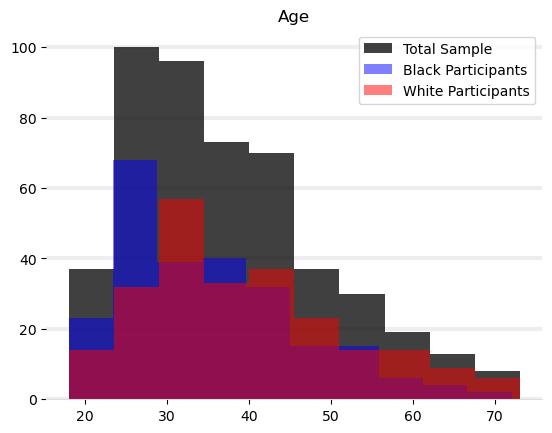

Mean News consumption bias for sample: -0.58 ( SD = 1.94 ; -5=Left & 0=Center & 5=Right)
Mean News consumption bias for White Participants: -0.48 ( SD = 2.17 ; 1=Left & 3=Center & 5=Right)
Mean News consumption bias for Black Participants: -0.67 ( SD = 1.67 ; 1=Left & 3=Center & 5=Right)


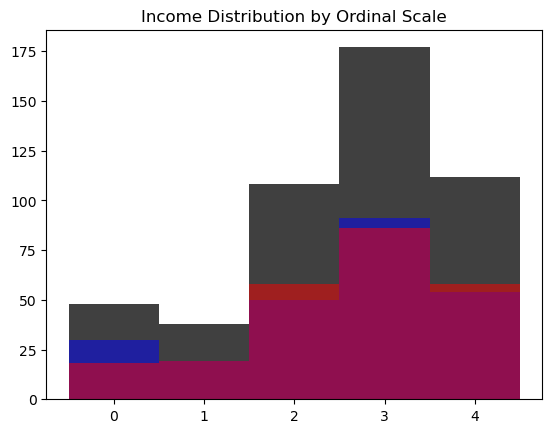

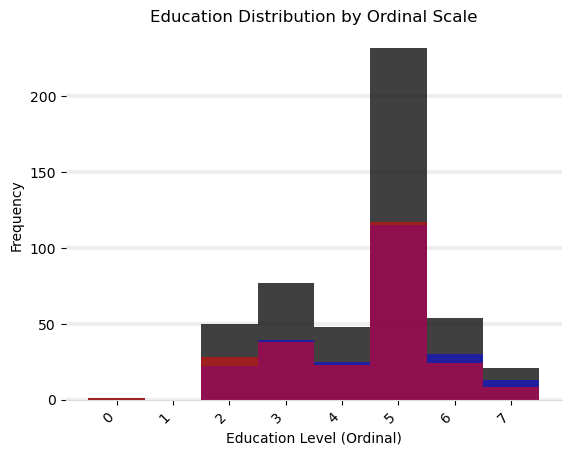

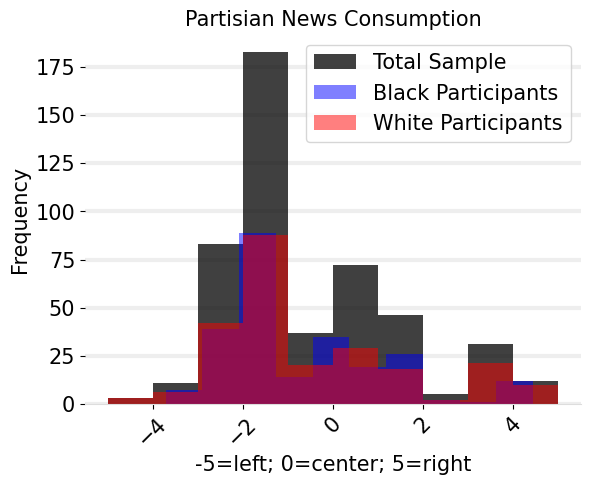

In [6]:
#@title Plot descriptive statistics
#Report Gender breakdown
propFemale = (sum(socioDemographicData['FemaleGender']=='1')/len(socioDemographicData['FemaleGender']))*100
propFemale = round(propFemale,2)
print('The sample is',propFemale, '% Female and', (100-propFemale),'% Male')

#Report racial breakdown
propBlack = (sum(socioDemographicData['Black or African American']==1)/len(socioDemographicData['Black or African American']))*100
propBlack = round(propBlack,2)
print('The sample is',propBlack, '% Black and', (100-propBlack),'% White')

#Create race masks
bIndx = socioDemographicData['Black or African American'] == 1
wIndx = socioDemographicData['Black or African American'] == 0

# Plot Age histograms
Age_mean = np.mean(socioDemographicData['Age_years'])
Age_sd = np.std(socioDemographicData['Age_years'])
print(f'Mean age for sample:', round(Age_mean,2), '( SD =', round(Age_sd,2), ')')
fig, ax = plt.subplots()
plt.hist(socioDemographicData['Age_years'], alpha=0.75, color= 'k')
plt.hist(socioDemographicData['Age_years'][bIndx], alpha=0.5, color= 'b')
plt.hist(socioDemographicData['Age_years'][wIndx], alpha=0.5, color= 'r')
plt.title('Age')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE', linewidth=3)
ax.xaxis.grid(False)
labels= ["Total Sample","Black Participants", "White Participants"]
plt.legend(labels)
plt.show()

# Plot Income histograms
IncPlot = socioDemographicData['IncomeOrdinal'].dropna()
bIncPlot = socioDemographicData['IncomeOrdinal'][bIndx].dropna()
wIncPlot = socioDemographicData['IncomeOrdinal'][wIndx].dropna()
plt.hist(IncPlot, bins=np.arange(len(customSort)+1)-0.5, alpha=0.75, color='k', label= 'Total Sample')
plt.hist(bIncPlot, bins=np.arange(len(customSort)+1)-0.5, alpha=0.5, color='b', label='Black Participants')
plt.hist(wIncPlot, bins=np.arange(len(customSort)+1)-0.5, alpha=0.5, color='r', label='White Participants')
plt.title('Income Distribution by Ordinal Scale')

#Plot Education
EduPlot = socioDemographicData['EducationOrdinal'].dropna()
bEduPlot = socioDemographicData['EducationOrdinal'][bIndx].dropna()
wEduPlot = socioDemographicData['EducationOrdinal'][wIndx].dropna()
  # Create a new figure and axes for the Education histogram
fig, ax = plt.subplots()
plt.hist(EduPlot, bins=np.arange(len(customSort_edu)+1)-0.5, alpha=0.75, color='k', label='Total Sample')
plt.hist(bEduPlot, bins=np.arange(len(customSort_edu)+1)-0.5, alpha=0.5, color='b', label='Black Participants')
plt.hist(wEduPlot, bins=np.arange(len(customSort_edu)+1)-0.5, alpha=0.5, color='r', label='White Participants')
plt.title('Education Distribution by Ordinal Scale')
plt.xlabel('Education Level (Ordinal)')
plt.ylabel('Frequency')
  # Customize the plot appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE', linewidth=3)
ax.xaxis.grid(False)
plt.xticks(rotation=45, ha='right')

# Plot NewsBias histograms
Newsbias_mean = np.mean(socioDemographicData['NewsBiasQuant'])
Newsbias_sd = np.std(socioDemographicData['NewsBiasQuant'])
Newsbias_mean_White = np.mean(socioDemographicData['NewsBiasQuant'][wIndx])
Newsbias_sd_White = np.std(socioDemographicData['NewsBiasQuant'][wIndx])
Newsbias_mean_Black = np.mean(socioDemographicData['NewsBiasQuant'][bIndx])
Newsbias_sd_Black = np.std(socioDemographicData['NewsBiasQuant'][bIndx])
print(f'Mean News consumption bias for sample:', round(Newsbias_mean,2), '( SD =', round(Newsbias_sd,2), '; -5=Left & 0=Center & 5=Right)')
print(f'Mean News consumption bias for White Participants:', round(Newsbias_mean_White,2), '( SD =', round(Newsbias_sd_White,2), '; 1=Left & 3=Center & 5=Right)')
print(f'Mean News consumption bias for Black Participants:', round(Newsbias_mean_Black,2), '( SD =', round(Newsbias_sd_Black,2), '; 1=Left & 3=Center & 5=Right)')

fig, ax = plt.subplots()
plt.hist(socioDemographicData['NewsBiasQuant'].sort_values(axis=0), alpha=0.75, color='k')
plt.hist(socioDemographicData['NewsBiasQuant'][bIndx].sort_values(axis=0), alpha=0.5, color='b')
plt.hist(socioDemographicData['NewsBiasQuant'][wIndx].sort_values(axis=0), alpha=0.5, color='r')
plt.title('Partisian News Consumption', size=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE', linewidth=3)
ax.xaxis.grid(False)
plt.xlabel('-5=left; 0=center; 5=right', size=15) #for ordinal
#plt.xlabel('5=left max; 0=center; 5=right max', size=15) #for hires
plt.ylabel('Frequency', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
labels= ["Total Sample","Black Participants", "White Participants"]
plt.legend(labels, prop={'size': 15})

plt.xticks(rotation = 45)
plt.show()

#### Breakdown of Black/White & Left/Right Combination

In [7]:
#Breakdown of B/W & L/R combinations
nBR = socioDemographicData[(socioDemographicData['Black or African American']==1) & (socioDemographicData['NewsBiasQuant']>0)].shape[0]
nBL = socioDemographicData[(socioDemographicData['Black or African American']==1) & (socioDemographicData['NewsBiasQuant']<0)].shape[0]

nWR = socioDemographicData[(socioDemographicData['Black or African American']==0) & (socioDemographicData['NewsBiasQuant']>0)].shape[0]
nWL = socioDemographicData[(socioDemographicData['Black or African American']==0) & (socioDemographicData['NewsBiasQuant']<0)].shape[0]

print('The number of Black American Right-leaning news consumers is:', nBR)
print('The number of Black American Left-leaning news consumers is:', nBL)
print('The number of White American Right-leaning news consumers is:', nWR)
print('The number of White American Left-leaning news consumers is:', nWL)

nBRM = socioDemographicData[(socioDemographicData['Black or African American']==1) & (socioDemographicData['NewsBiasQuant']>0) & (socioDemographicData['FemaleGender']=='0')].shape[0]
nBRF = socioDemographicData[(socioDemographicData['Black or African American']==1) & (socioDemographicData['NewsBiasQuant']>0) & (socioDemographicData['FemaleGender']=='1')].shape[0]
nBLM = socioDemographicData[(socioDemographicData['Black or African American']==1) & (socioDemographicData['NewsBiasQuant']<0) & (socioDemographicData['FemaleGender']=='0')].shape[0]
nBLF = socioDemographicData[(socioDemographicData['Black or African American']==1) & (socioDemographicData['NewsBiasQuant']<0) & (socioDemographicData['FemaleGender']=='1')].shape[0]

print('\nThe number of Black American Right-leaning news consumers who identify as men is:', nBRM)
print('The number of Black American Right-leaning news consumers who identify as women is:', nBRF)
print('The number of Black American Left-leaning news consumers who identify as men is:', nBLM)
print('The number of Black American Left-leaning news consumers who identify as women is:', nBLF)

nWRM = socioDemographicData[(socioDemographicData['Black or African American']==0) & (socioDemographicData['NewsBiasQuant']>0) & (socioDemographicData['FemaleGender']=='0')].shape[0]
nWRF = socioDemographicData[(socioDemographicData['Black or African American']==0) & (socioDemographicData['NewsBiasQuant']>0) & (socioDemographicData['FemaleGender']=='1')].shape[0]
nWLM = socioDemographicData[(socioDemographicData['Black or African American']==0) & (socioDemographicData['NewsBiasQuant']<0) & (socioDemographicData['FemaleGender']=='0')].shape[0]
nWLF = socioDemographicData[(socioDemographicData['Black or African American']==0) & (socioDemographicData['NewsBiasQuant']<0) & (socioDemographicData['FemaleGender']=='1')].shape[0]

print('\nThe number of White American Right-leaning news consumers who identify as men is:', nWRM)
print('The number of White American Right-leaning news consumers who identify as women is:', nWRF)
print('The number of White American Left-leaning news consumers who identify as men is:', nWLM)
print('The number of White American Left-leaning news consumers who identify as women is:', nWLF)
print('The difference between 483 and 478 comes from people who have exactly a 0 for news bias consumption')


The number of Black American Right-leaning news consumers is: 82
The number of Black American Left-leaning news consumers is: 158
The number of White American Right-leaning news consumers is: 79
The number of White American Left-leaning news consumers is: 159

The number of Black American Right-leaning news consumers who identify as men is: 45
The number of Black American Right-leaning news consumers who identify as women is: 37
The number of Black American Left-leaning news consumers who identify as men is: 77
The number of Black American Left-leaning news consumers who identify as women is: 81

The number of White American Right-leaning news consumers who identify as men is: 40
The number of White American Right-leaning news consumers who identify as women is: 39
The number of White American Left-leaning news consumers who identify as men is: 78
The number of White American Left-leaning news consumers who identify as women is: 81
The difference between 483 and 478 comes from people w

#### Comparing Black-Right/Black-Left/White-Right/White-Left subgraphs seeding Religion

In [8]:
#Create masks for identity-interaction
BR_mask = ((socioDemographicData['Black or African American']==1) & (socioDemographicData['NewsBiasQuant']>0))
BL_mask = ((socioDemographicData['Black or African American']==1) & (socioDemographicData['NewsBiasQuant']<0))
WR_mask = ((socioDemographicData['Black or African American']==0) & (socioDemographicData['NewsBiasQuant']>0))
WL_mask = ((socioDemographicData['Black or African American']==0) & (socioDemographicData['NewsBiasQuant']<0))

#Create subgraph seeding 'Religion'
Religion_PRaM = PRaM_rating.loc[:,PRaM_rating.columns.str.contains('religion', case=False)]
BR_Religion_PRaM = Religion_PRaM[BR_mask].mean(axis=0)
BL_Religion_PRaM = Religion_PRaM[BL_mask].mean(axis=0)
WR_Religion_PRaM = Religion_PRaM[WR_mask].mean(axis=0)
WL_Religion_PRaM = Religion_PRaM[WL_mask].mean(axis=0)
RaceNews_Religion_PRaM = pd.DataFrame({'BR_Religion_PRaM':BR_Religion_PRaM, 'BL_Religion_PRaM':BL_Religion_PRaM, 'WR_Religion_PRaM':WR_Religion_PRaM, 'WL_Religion_PRaM':WL_Religion_PRaM})
display(RaceNews_Religion_PRaM)

Religion_BelBeh = conceptBeliefDecision.loc[:,conceptBeliefDecision.columns.str.contains('religion', case=False)]
BR_Religion_BelBeh = Religion_BelBeh[BR_mask].sum(axis=0)/sum(BR_mask)
BL_Religion_BelBeh = Religion_BelBeh[BL_mask].sum(axis=0)/sum(BL_mask)
WR_Religion_BelBeh = Religion_BelBeh[WR_mask].sum(axis=0)/sum(WR_mask)
WL_Religion_BelBeh = Religion_BelBeh[WL_mask].sum(axis=0)/sum(WL_mask)
RaceNews_Religion_BelBeh = pd.DataFrame({'BR_Religion_BelBeh':BR_Religion_BelBeh, 'BL_Religion_BelBeh':BL_Religion_BelBeh, 'WR_Religion_BelBeh':WR_Religion_BelBeh, 'WL_Religion_BelBeh':WL_Religion_BelBeh})
display(RaceNews_Religion_BelBeh)



,BR_Religion_PRaM,BL_Religion_PRaM,WR_Religion_PRaM,WL_Religion_PRaM
police-religion,-0.829268,-0.797468,-0.886076,-1.100629
firefighter-religion,-1.378049,-1.253165,-1.569620,-1.427673
neighbors(yours)-religion,1.682927,0.721519,1.000000,0.849057
conservatives(political)-religion,1.207317,2.727848,2.493671,4.044025
liberals(political)-religion,0.390244,-0.594937,-1.772152,-1.603774
healthcare-religion,-0.085366,-0.487342,-0.848101,-1.666667
voting-religion,0.097561,-0.050633,-0.405063,-0.459119
immigration-religion,-0.231707,-0.443038,-0.354430,-0.540881
religion-science,-1.060976,-1.759494,-2.354430,-4.056604
religion-anger,0.121951,0.018987,-0.974684,1.150943


,BR_Religion_BelBeh,BL_Religion_BelBeh,WR_Religion_BelBeh,WL_Religion_BelBeh
I believe organized religion serves a net societal good.,0.756098,0.639241,0.683544,0.389937
I believe that religion as an institution is generally inclusive to all people.,0.719512,0.56962,0.797468,0.314465
I believe that religion should be considered in political affairs.,0.573171,0.310127,0.417722,0.18239
When I am going through a hard time I turn to religion for comfort.,0.707317,0.607595,0.658228,0.289308


#### Descriptive analysis of PRaM

PRaM reliability for Total sample: 0.9
PRaM reliability for Black sample: 0.92
PRaM reliability for White sample: 0.87


C:\Users\rober\AppData\Local\Temp\ipykernel_15668\607966449.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Wmat[i,j] = PairData[t]
C:\Users\rober\AppData\Local\Temp\ipykernel_15668\607966449.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Wmat[j,i] = PairData[t]


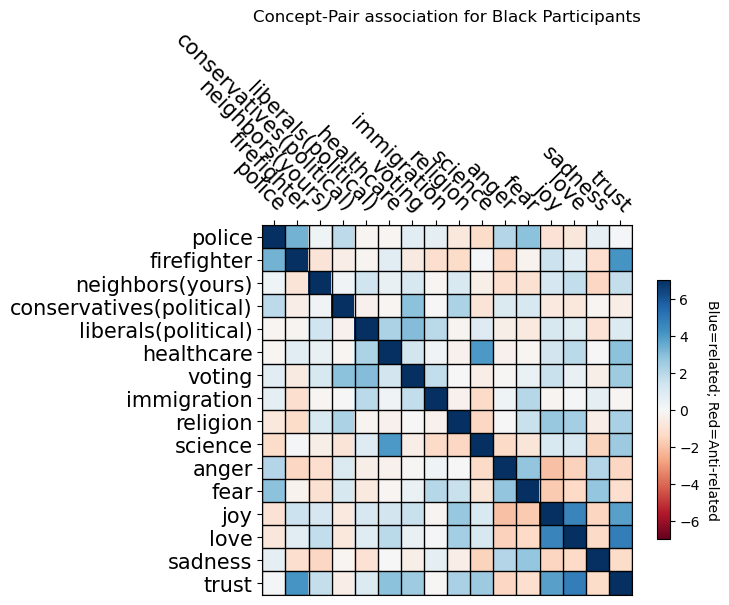

C:\Users\rober\AppData\Local\Temp\ipykernel_15668\607966449.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Wmat[i,j] = PairData[t]
C:\Users\rober\AppData\Local\Temp\ipykernel_15668\607966449.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Wmat[j,i] = PairData[t]


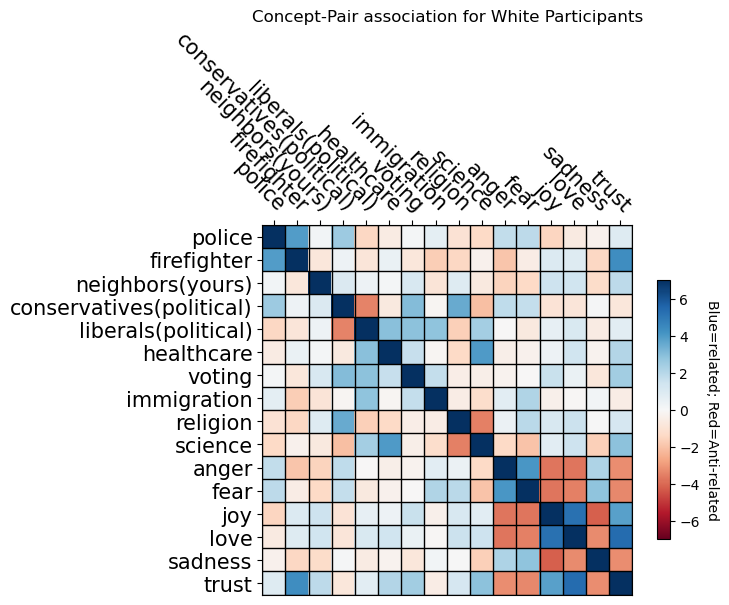

C:\Users\rober\AppData\Local\Temp\ipykernel_15668\607966449.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Wmat[i,j] = PairData[t]
C:\Users\rober\AppData\Local\Temp\ipykernel_15668\607966449.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Wmat[j,i] = PairData[t]


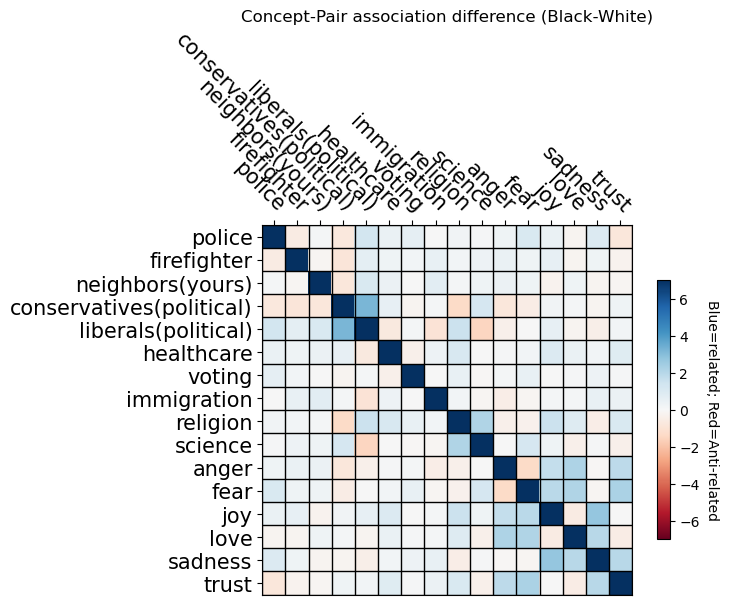

In [9]:
# @title Descriptive analysis of PRaM
#Subset data for Black and White Participants
bPRaM = PRaM_rating.loc[bIndx]
wPRaM = PRaM_rating.loc[wIndx]

# Average pair distance
avgDist = np.mean(PRaM_rating, axis=0)
avgBDist = np.mean(bPRaM, axis=0)
avgWDist = np.mean(wPRaM, axis=0)

#Participant-wise normalization
PRaMz = stats.zscore(PRaM_rating, axis=0)
bPRaMz = stats.zscore(bPRaM, axis=0)
wPRaMz = stats.zscore(wPRaM, axis=0)

#Convert to dataframes for Reliabiltiy calc
PRaMz = pd.DataFrame(PRaMz)
bPRaMz = pd.DataFrame(bPRaMz)
wPRaMz = pd.DataFrame(wPRaMz)

# Splithalf Reliability
perm = 10000
rhoPRaM = splitHalf_Reliability(PRaMz, perm)
rhobPRaM = splitHalf_Reliability(bPRaMz, perm)
rhowPRaM = splitHalf_Reliability(wPRaMz, perm)
print(f'PRaM reliability for Total sample:', round(rhoPRaM,2))
print(f'PRaM reliability for Black sample:', round(rhobPRaM,2))
print(f'PRaM reliability for White sample:', round(rhowPRaM,2))

# Generate distance matricies
bPRaM_Weights = weightedHeatmap(avgBDist, words,1, "Concept-Pair association for Black Participants", 'Blue=related; Red=Anti-related'); # Compute association matrix for Black participants
wPRaM_Weights = weightedHeatmap(avgWDist, words,1, "Concept-Pair association for White Participants", 'Blue=related; Red=Anti-related'); # Compute association matrix for White participants
diffPRaM_Weights = weightedHeatmap((avgBDist-avgWDist), words,1, "Concept-Pair association difference (Black-White)", 'Blue=related; Red=Anti-related'); # Compute association matrix for Black-White differences

### Inferential Statistics and Specific Hypothesis Testing

#### H1: Permuted multiple regression model to measure concept-pair edge-length differences

In [10]:
# @title Execute Permuted Multiple regression model to measure concept-pair edge-length differences across sociodemographic factors and news consumption

#Measure Word-Pair differences across group variables
#Permuted Multiple Regression model

#Y is 120 pair-distances (seperate models for each word pair)
#X contains all group breakdowns (dummy coded for discrete; sequentialized for ordinal variables)
#Permutation-testing (scramble Y) and FDR correction are also computed

#Group breakdown:
#----------------------------
#Race (Black identity is dummy coded)
#Gender (Female identity is dummy coded)
#Income (Coverted to an ordinal scale with higher values meaning greater income bracket)
#Age (in years)
#Education (Coverted to an ordinal scale with higher values meaning greater level of education compleated)
#NewsBiasConsumption=Political

#NOTE: FOR THIS STUDY WE IMPLEMENTED A FAR MORE COMPUTATIONALLY EFFICIENT VERSION OF THE GLM from Vargas & Verstynen, 2025

outPath = r'C:\Users\rober\Dropbox\Professional\GitHub\SG_GeometryBasedBeliefsAndDecisions\output'

#Use existing 100,000 iteration output (1 = yes; 0 = no)
use100000iter = 1

#Concatonate
X = socioDemographicData.drop(columns='ParticipantID')
# X = np.concatenate((blackCoded, femaleCoded, Income, Age, Edu, NewsBias), axis=1) [discontinued]

#Y: Pair data
Y = PRaM_edge #Use 'PRaM_rating' for similarity-rating based analysis

bObsPairsPRaM = []
pPairsPRaM = []
perm = 10
#Iterate through concept-pairs
for i in tqdm(range(len(PairLabel))):
    # Isolate pair data
    Ypairi = Y[Y.columns[i]]

    #Dummy coded linear regression
    #Compared against permuted distribution
    betaObs_PRaM, pval_PRaM, betaPerm1 = regPairDiff_test(X, Ypairi, perm)

    #Update output
    bObsPairsPRaM.append(betaObs_PRaM)
    pPairsPRaM.append(pval_PRaM)

pPairsPRaM = pd.DataFrame(pPairsPRaM) #Convert to dataframe
bObsPairsPRaM = pd.DataFrame(bObsPairsPRaM)#Convert to dataframe

#Implement FDR correction
FDR_sig = []
import statsmodels as sm
for g in range(X.shape[1]):
  FDR = sm.stats.multitest.fdrcorrection(np.array(pPairsPRaM[g+1]), alpha=0.05, method='indep', is_sorted=False)#+1 is to account for constant in original model
  FDR_sig.append(FDR[0])
FDR_sig = pd.DataFrame(FDR_sig)

#Export data to CSV files
if use100000iter == 0:
  PrAM_GLMdata = pd.DataFrame(PRaM_edge)
  FDR_sig.to_csv('FDRsig_edge_100000.csv')
  pPairsPRaM.to_csv('pValPairs_edge_100000.csv')
  bObsPairsPRaM.to_csv('bObsPairsPRaM_edge_100000.csv')
  PrAM_GLMdata.to_csv('PRaM_GLMdata_edge_100000.csv')
elif use100000iter == 1:
  FDR_sig = pd.read_csv (outPath + '\FDRsig_edge_100000.csv', header=0, index_col=0)
  pPairsPRaM = pd.read_csv (outPath + '\pValPairs_edge_100000.csv', header=0, index_col=0) #First column refers to constant parameter
  bObsPairsPRaM = pd.read_csv (outPath + r'\bObsPairsPRaM_edge_100000.csv', header=0, index_col=0)
  PrAM_GLMdata = pd.read_csv (outPath + '\PrAM_GLMdata_edge_100000.csv', header=0, index_col=0)

100%|██████████| 120/120 [00:00<00:00, 557.66it/s]


#### H2: Permuted multiple logistic regression model to measure belief/decision making differences across sociodemographic factors

In [ ]:
# @title Execute permuted multiple logistic regression model to measure belief/decision making differences across sociodemographic variables

#Measure Agree/Disagree of Belief/Decision differences across sociodemographic variables
#Permuted Multiple Logistic Regression model

#Y is XX items of the Agree/Disagree decision/belief questionaire(seperate models for each item)
#X contains all group breakdowns (dummy coded for discrete; sequentialized for ordinal variables)
#Permutation-testing (scramble Y) and FDR correction are also computed

#Group breakdown:
#----------------------------
#Race (Black identity is dummy coded)
#Gender (Female identity is dummy coded)
#Income (Coverted to an ordinal scale with higher values meaning greater income bracket)
#Age (in years)
#Education (Coverted to an ordinal scale with higher values meaning greater level of education compleated)
#NewsBiasConsumption=Political

#Use existing 10,000 iteration output (1 = yes; 0 = no)
use100000iter = 0

#Concatonate
X = socioDemographicData.drop(columns='ParticipantID')
# X = np.concatenate((blackCoded, femaleCoded, Income, Age, Edu, NewsBias), axis=1) [discontinued]

#Y: Agree/Disagree items
Y = conceptBeliefDecision #Belief agree and disagree items

#INCLUDE PARAMETER THAT LETS YOU CHOOSE WHETHER IT IS WEIGHTED OR NON WEIGHTED
#LOOK INTO USING F1 Score

bObsconceptBD = []
pconceptBD = []
metricsBD = []
pAccBD = []
cmObsBD = []
perm = 10000
#Iterate through concept-pairs
for i in tqdm(range(conceptBeliefDecision.shape[1])):
    # Isolate pair data
    Ypairi = Y[Y.columns[i]]

    #Dummy coded linear regression
    #Compared against permuted distribution
    # betaObs_model, pval_model, betaPerm1, accObs, accPerm, accPval = permLogisticRegression_metrics(X, Ypairi, perm)
    betaObs_model, pval_beta, betaPerm, metrics_obs, metrics_perm, cm_obs, acc_pval = \
        permLogisticRegression_metrics(X, Ypairi, perm, class_weight='balanced', random_state=8006)
    
    summary_df = summarize_permutation_pvals(metrics_obs, metrics_perm)
    print(summary_df.sort_values("Permutation p-val"))
    print("Observed Confusion Matrix:\n", cm_obs)

    #Update output
    bObsconceptBD.append(betaObs_model)
    pconceptBD.append(pval_beta)
    metricsBD.append(summary_df)
    pAccBD.append(acc_pval)
    cmObsBD.append(cm_obs)


pconceptBD = pd.DataFrame(pconceptBD)
bObsconceptBD = pd.DataFrame(bObsconceptBD)
accObsBD = pd.DataFrame(metricsBD)
pAccBD = pd.DataFrame(pAccBD)

#Implement FDR correction
FDR_sigbetaBD = []
import statsmodels as sm
for g in range(X.shape[1]):
  FDR = sm.stats.multitest.fdrcorrection(np.array(pconceptBD[g+1]), alpha=0.05, method='indep', is_sorted=False)#+1 is to account for constant in original model
  FDR_sigbetaBD.append(FDR[0])
FDR_sigbetaBD = pd.DataFrame(FDR_sigbetaBD)

FDR_sigAccBD = sm.stats.multitest.fdrcorrection(np.array(pAccBD[0]), alpha=0.05, method='indep', is_sorted=False)
FDR_sigAccBD = pd.DataFrame(FDR_sigAccBD) #add code to drop the row of adjusted p values

#Export data to CSV files
if use100000iter == 0:
  conceptBeliefDecision_GLMdata = pd.DataFrame(conceptBeliefDecision)
  FDR_sigbetaBD.to_csv('decisionBeliefGLM_FDR_sigbetaBD_edge_100000.csv')
  pconceptBD.to_csv('decisionBeliefGLM_pconceptBD_edge_100000.csv')
  bObsconceptBD.to_csv('decisionBeliefGLM_bObsconceptBD_edge_100000.csv')
  accObsBD.to_csv('decisionBeliefGLM_accObsBD_edge_100000.csv')
  conceptBeliefDecision_GLMdata.to_csv('conceptBeliefDecision_GLMdata_edge_100000.csv')
  pAccBD.to_csv('decisionBeliefGLM_pAccBD_edge_100000.csv')
  FDR_sigAccBD.to_csv('decisionBeliefGLM_FDR_sigAccBD_edge_100000.csv')

elif use100000iter == 1:
  # conceptBeliefDecision_GLMdata = pd.DataFrame(conceptBeliefDecision)
  FDR_sigbetaBD = pd.read_csv (path + 'analysis/decisionBeliefGLM_FDR_sigbetaBD_edge_100000.csv', header=0, index_col=0)
  pconceptBD = pd.read_csv (path + 'analysis/decisionBeliefGLM_pconceptBD_edge_100000.csv', header=0, index_col=0) #First column refers to constant parameter
  bObsconceptBD = pd.read_csv (path + 'analysis/decisionBeliefGLM_bObsconceptBD_edge_100000.csv', header=0, index_col=0)
  accObsBD = pd.read_csv (path + 'analysis/decisionBeliefGLM_accObsBD_edge_100000.csv', header=0, index_col=0)
  conceptBeliefDecision_GLMdata = pd.read_csv (path + 'analysis/conceptBeliefDecision_GLMdata_edge_100000.csv', header=0, index_col=0)
  pAccBD = pd.read_csv(path + 'analysis/decisionBeliefGLM_pAccBD_edge_100000.csv', header=0, index_col=0)
  FDR_sigAccBD = pd.read_csv(path + 'analysis/decisionBeliefGLM_FDR_sigAccBD_edge_100000.csv', header=0, index_col=0)


  2%|▎         | 1/40 [04:13<2:44:29, 253.06s/it]

                Metric  Observed  Null Mean  Null Std  Permutation p-val
0             accuracy  0.720497   0.562755  0.032675           0.000100
1      precision_macro  0.598802   0.528200  0.011824           0.000100
2      precision_micro  0.720497   0.562755  0.032675           0.000100
3   precision_weighted  0.870611   0.824222  0.010587           0.000100
4         recall_macro  0.715527   0.568817  0.028583           0.000100
5         recall_micro  0.720497   0.562755  0.032675           0.000100
6      recall_weighted  0.720497   0.562755  0.032675           0.000100
7             f1_macro  0.593457   0.462575  0.022196           0.000100
8             f1_micro  0.720497   0.562755  0.032675           0.000100
9          f1_weighted  0.768960   0.641147  0.028031           0.000100
10           f1_class0  0.366197   0.231341  0.020562           0.000100
11           f1_class1  0.820717   0.693809  0.030199           0.000100
12    precision_class0  0.246835   0.144879  0.0137

  5%|▌         | 2/40 [08:26<2:40:14, 253.02s/it]

                Metric  Observed  Null Mean  Null Std  Permutation p-val
20               brier  0.246965   0.245158  0.002837           0.300470
21            log_loss  0.686882   0.683313  0.005842           0.310869
14       recall_class0  0.569892   0.559913  0.046802           0.462654
10           f1_class0  0.317365   0.324930  0.021877           0.632237
13    precision_class1  0.834711   0.839766  0.013716           0.640336
3   precision_weighted  0.716334   0.722211  0.014085           0.661634
19              pr_auc  0.841387   0.847157  0.012666           0.669033
4         recall_macro  0.543921   0.554995  0.023561           0.679832
16   balanced_accuracy  0.543921   0.554995  0.023561           0.679832
17                 mcc  0.069272   0.087118  0.037375           0.682932
1      precision_macro  0.527314   0.534502  0.014827           0.684332
12    precision_class0  0.219917   0.229238  0.016373           0.712529
7             f1_macro  0.478303   0.494492  0.0212

  8%|▊         | 3/40 [12:37<2:35:36, 252.33s/it]

                Metric  Observed  Null Mean  Null Std  Permutation p-val
0             accuracy  0.741201   0.573113  0.036365           0.000100
1      precision_macro  0.565764   0.523827  0.010145           0.000100
2      precision_micro  0.741201   0.573113  0.036365           0.000100
5         recall_micro  0.741201   0.573113  0.036365           0.000100
7             f1_macro  0.555887   0.443654  0.022973           0.000100
6      recall_weighted  0.741201   0.573113  0.036365           0.000100
9          f1_weighted  0.798815   0.670213  0.030198           0.000100
8             f1_micro  0.741201   0.573113  0.036365           0.000100
12    precision_class0  0.171642   0.103517  0.012247           0.000100
15       recall_class1  0.751121   0.571448  0.039820           0.000100
10           f1_class0  0.269006   0.176103  0.019738           0.000100
11           f1_class1  0.842767   0.711204  0.031742           0.000100
18             roc_auc  0.760484   0.613364  0.0340

 10%|█         | 4/40 [16:43<2:29:59, 249.99s/it]

                Metric  Observed  Null Mean  Null Std  Permutation p-val
0             accuracy  0.708075   0.560384  0.031788           0.000100
2      precision_micro  0.708075   0.560384  0.031788           0.000100
6      recall_weighted  0.708075   0.560384  0.031788           0.000100
5         recall_micro  0.708075   0.560384  0.031788           0.000100
7             f1_macro  0.569549   0.467230  0.022001           0.000100
11           f1_class1  0.813738   0.689212  0.029778           0.000100
9          f1_weighted  0.753070   0.634061  0.027456           0.000100
8             f1_micro  0.708075   0.560384  0.031788           0.000100
15       recall_class1  0.728132   0.558451  0.037667           0.000100
12    precision_class0  0.228188   0.156141  0.014171           0.000100
18             roc_auc  0.730122   0.591464  0.027846           0.000100
10           f1_class0  0.325359   0.245248  0.020803           0.000300
19              pr_auc  0.943294   0.908109  0.0097

#### H3: Cross-validated predictive model using graphical alignment to predict behavior/belief aligment
*   For H3 analysis: compute permutation test within each cross-validation fold (scramble Y) do 10k
*   Compute R^2 as your fit statistic because it is not sensitive to scale
*   Test the full model; subset race-differing edges; subset news differing edges
*   Run models on each item individually; using a logistic model. aggree or disagree -> base-rates = ((P(agree)_L*n_L) * (P(agree)_R*n_R))/(n_L+n_R)

In [67]:
#Do any participant and item subsetting outside
#Make sure a seed is specified so the same test set is used every time (default: 8006)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import random
from itertools import combinations


#Use the index of the participant_ID vector to 
keyID = socioDemographicData['ParticipantID']
validationN = 20
testN = 20 #10 participants will be left out
PRaM_dat = PRaM_rating
BelBeh_dat = conceptBeliefDecision

#Remove parantheticals and shorten names for easier reading
PRaM_dat.columns = [clean_column_name(col) for col in PRaM_dat.columns]

def cv_alignment_prediction(keyID, PRaM_dat, BelBeh_dat, testN, validationN):

    #Isolate test data
    testIDsIdx = random.sample(sorted(keyID.index), testN)
    testIDs = keyID[testIDsIdx] #To be measures using the final set of weights

    #This will be used for the trianing and validaiton set to generate weights for test set
    training_IDs = keyID[~keyID.index.isin(testIDsIdx)]

    #Define the indeces for each fold in the subseqent CV loop
    folds = []
    remTraining = training_IDs.copy()
    while not remTraining.empty:
        if len(remTraining) > validationN:
            valIDIdx = random.sample(sorted(remTraining.index), validationN)
            remTraining = remTraining[~remTraining.index.isin(valIDIdx)]
            folds.append(valIDIdx)
        else:
            folds.append(remTraining.index)
            remTraining = pd.Series()

    print(f'With leave-{validationN}-out, there will be {len(folds)} folds.')

    #Learn training weights and compute MSE
    training_MSE = []
    validation_MSE = []    
    foldWeights = []

    for i, fold in enumerate(folds):
        print(f"Processing fold {i + 1} of {len(folds)}")
        #Subset training data
        trainPRaM = PRaM_dat[~PRaM_dat.index.isin(fold)]
        trainBelBeh = BelBeh_dat[~BelBeh_dat.index.isin(fold)]

        #Compute alignment for all pair-wise participants in training set
        combIdx = [list(c) for c in combinations(range(trainPRaM.shape[0]), 2)]
        trainX = [abs(trainPRaM.iloc[a] - trainPRaM.iloc[b]) for [a, b] in combIdx] #trainPRaM_align
        trainY = [trainBelBeh.iloc[a] == trainBelBeh.iloc[b] for [a, b] in combIdx] #trainBelBeh_align
        trainX = pd.DataFrame(trainX)
        trainY = pd.DataFrame(trainY).astype(int)
        trainY = pd.DataFrame(trainY.mean(axis=1))

        #Obtain training weights and predict on training set
        model = LinearRegression()
        model.fit(trainX, trainY)
        trainingW = model.coef_
        trainPred = model.predict(trainX)
        trMSE = mean_squared_error(trainY, trainPred)

        training_MSE.append(trMSE) #store fold trMSE
        foldWeights.append(trainingW) #store fold weights


        #Subset validation data
        valPRaM = PRaM_dat.loc[fold]
        valBelBeh = BelBeh_dat.loc[fold]
        combIdx = [list(c) for c in combinations(range(valPRaM.shape[0]), 2)]
        valX = [abs(valPRaM.iloc[a] - valPRaM.iloc[b]) for [a, b] in combIdx] #valPRaM_align
        valY = [valBelBeh.iloc[a] == valBelBeh.iloc[b] for [a, b] in combIdx] #valBelBeh_align
        valX = pd.DataFrame(valX)
        valY = pd.DataFrame(valY).astype(int)
        valY = pd.DataFrame(valY.mean(axis=1))        

        #Apply training weights to validation set
        valPred = model.predict(valX)
        vMSE = mean_squared_error(valY, valPred)
        validation_MSE.append(vMSE)

    #Mean of training weights
    mean_trW = np.array(foldWeights)
    mean_trW = pd.DataFrame(mean_trW.reshape(mean_trW.shape[0], mean_trW.shape[2])).mean(axis=0)
    
    #Prepare test data
    testPRaM = PRaM_dat.loc[testIDsIdx]
    testBelBeh = BelBeh_dat.loc[testIDsIdx]
    combIdx = [list(c) for c in combinations(range(testPRaM.shape[0]), 2)]
    testX = [abs(testPRaM.iloc[a] - testPRaM.iloc[b]) for [a, b] in combIdx] #valPRaM_align
    testY = [testBelBeh.iloc[a] == testBelBeh.iloc[b] for [a, b] in combIdx] #valBelBeh_align
    testX = pd.DataFrame(testX)
    testY = pd.DataFrame(testY).astype(int)
    testY = pd.DataFrame(testY.mean(axis=1))   

    #Apply training weights to test set
    testPred = model.predict(testX)
    test_MSE = mean_squared_error(testY, testPred)

    return training_MSE, validation_MSE, test_MSE, testIDs, training_IDs, foldWeights #Fold weights is going to be used to test 

With leave-20-out, there will be 24 folds.
Processing fold 1 of 24
Processing fold 2 of 24
Processing fold 3 of 24
Processing fold 4 of 24
Processing fold 5 of 24
Processing fold 6 of 24
Processing fold 7 of 24
Processing fold 8 of 24
Processing fold 9 of 24
Processing fold 10 of 24
Processing fold 11 of 24
Processing fold 12 of 24
Processing fold 13 of 24
Processing fold 14 of 24
Processing fold 15 of 24
Processing fold 16 of 24
Processing fold 17 of 24
Processing fold 18 of 24
Processing fold 19 of 24
Processing fold 20 of 24
Processing fold 21 of 24
Processing fold 22 of 24
Processing fold 23 of 24
Processing fold 24 of 24


C:\Users\rober\AppData\Local\Temp\ipykernel_17696\2302351270.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Type", y="MSE", data=mse_df, palette={"Training": "skyblue", "Validation": "lightgreen"})


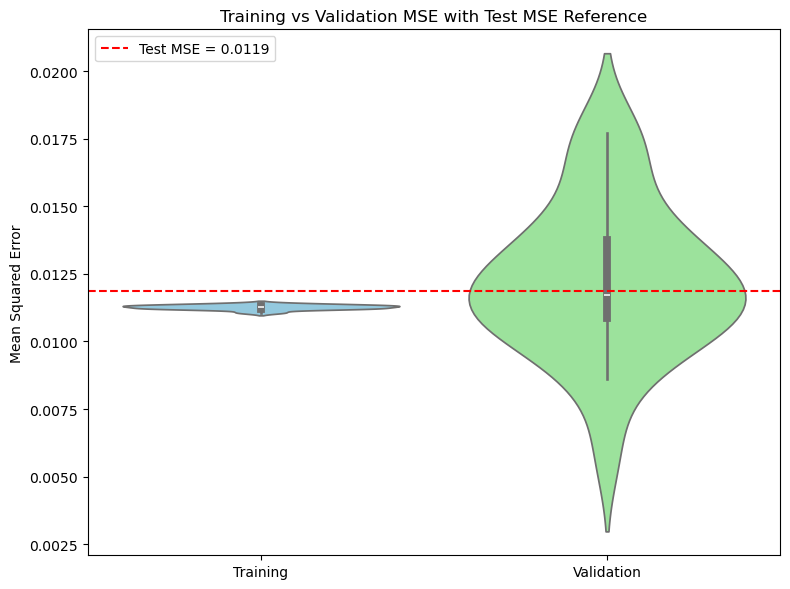

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Run your CV function
training_MSE, validation_MSE, test_MSE, testIDs, training_IDs, foldWeights = cv_alignment_prediction(
    keyID, PRaM_dat, BelBeh_dat, testN, validationN
)

# Prepare DataFrame for plotting
mse_df = pd.DataFrame({
    "MSE": training_MSE + validation_MSE,
    "Type": ["Training"] * len(training_MSE) + ["Validation"] * len(validation_MSE)
})

# Create the violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(x="Type", y="MSE", data=mse_df, palette={"Training": "skyblue", "Validation": "lightgreen"})

# Add a red horizontal line for test MSE
plt.axhline(y=test_MSE, color='red', linestyle='--', label=f'Test MSE = {test_MSE:.4f}')

# Label and style
plt.title("Training vs Validation MSE with Test MSE Reference")
plt.ylabel("Mean Squared Error")
plt.xlabel("")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
print('training mse = ',np.mean(training_MSE))
print('validation mse = ',np.mean(validation_MSE))

training mse =  0.011277134817716958
training mse =  0.011755825894120886


In [18]:
# @title Structure and Subset data for vizualization

#Isolate booleans of significant edges
sigEdges = FDR_sig.transpose()
sigEdges = sigEdges.reset_index(drop=True)
sigEdges_race = sigEdges[0]
sigEdges_gender = sigEdges[1]
sigEdges_income = sigEdges[2]
sigEdges_age = sigEdges[3]
sigEdges_edu = sigEdges[4]
sigEdges_newsBias = sigEdges[5]

#Subset
#Isolate Black and White samples and subset by sig edges
bfIdx = socioDemographicData['Black or African American'] == 1
wfIdx = socioDemographicData['Black or African American'] == 0
bfPRaM = PRaM_rating[bfIdx]
wfPRaM = PRaM_rating[wfIdx]
bfPRaM_sigEdges = bfPRaM.loc[:,sigEdges_race.values]
wfPRaM_sigEdges = wfPRaM.loc[:,sigEdges_race.values]
raceEdges = PairLabel[sigEdges_race]

#Seperate news bias consumption into left and right leaning
leftNewsIdx = socioDemographicData['NewsBiasQuant'] < 0
rightNewsIdx = socioDemographicData['NewsBiasQuant'] > 0
lfPRaM = PRaM_rating[leftNewsIdx]
rtPRaM = PRaM_rating[rightNewsIdx]
lfPRaM_sigEdges = lfPRaM.loc[:,sigEdges_newsBias.values]
rtPRaM_sigEdges = rtPRaM.loc[:,sigEdges_newsBias.values]
newsEdges = PairLabel[sigEdges_newsBias]

#Compute subset means and SEM
bfsePRaM_mean = bfPRaM_sigEdges.mean(axis=0)
wfsePRaM_mean = wfPRaM_sigEdges.mean(axis=0)
bfsePRaM_SEM = np.std(bfPRaM_sigEdges, axis=0)/np.sqrt(bfPRaM_sigEdges.shape[0])
wfsePRaM_SEM = np.std(wfPRaM_sigEdges, axis=0)/np.sqrt(wfPRaM_sigEdges.shape[0])

lfsePRaM_mean = lfPRaM_sigEdges.mean(axis=0)
rtsePRaM_mean = rtPRaM_sigEdges.mean(axis=0)
lfsePRaM_SEM = np.std(lfPRaM_sigEdges, axis=0)/np.sqrt(lfPRaM_sigEdges.shape[0])
rtsePRaM_SEM = np.std(rtPRaM_sigEdges, axis=0)/np.sqrt(rtPRaM_sigEdges.shape[0])


In [ ]:
#@title Show agreement differences for Race and News differing Belief and Decision items

# Hard code removal until you can debug these items
FDR_sigbetaBD['0'][0] = False
FDR_sigbetaBD['34'][0] = False

#FDR Output
# 0: Race
# 5: News bias
blackPdiffRaceBD = conceptBeliefDecision.loc[bfIdx,list(FDR_sigbetaBD.T[0])]
whitePdiffRaceBD = conceptBeliefDecision.loc[wfIdx,list(FDR_sigbetaBD.T[0])]
raceMeanAgreementBD = pd.DataFrame({'BlackAvgAgreement': blackPdiffRaceBD.mean(axis=0), 'WhiteAvgAgreement':whitePdiffRaceBD.mean(axis=0)})
countsBlackBD = blackPdiffRaceBD.sum(axis=0)
nBlack = blackPdiffRaceBD.shape[0]
countsWhiteBD = whitePdiffRaceBD.sum(axis=0)
nWhite = whitePdiffRaceBD.shape[0]

ci_bounds = countsBlackBD.apply(lambda x: wilson_ci(x, nBlack))
raceMeanAgreementBD[['ci_lowerBlack', 'ci_upperBlack']] = pd.DataFrame(ci_bounds.tolist(), index=raceMeanAgreementBD.index)

ci_bounds = countsWhiteBD.apply(lambda x: wilson_ci(x, nWhite))
raceMeanAgreementBD[['ci_lowerWhite', 'ci_upperWhite']] = pd.DataFrame(ci_bounds.tolist(), index=raceMeanAgreementBD.index)



leftPdiffNewsBD = conceptBeliefDecision.loc[leftNewsIdx,list(FDR_sigbetaBD.T[5])]
rightPdiffNewsBD = conceptBeliefDecision.loc[rightNewsIdx,list(FDR_sigbetaBD.T[5])]
newsMeanAgreementBD = pd.DataFrame({'LeftAvgAgreement': leftPdiffNewsBD.mean(axis=0), 'RightAvgAgreement':rightPdiffNewsBD.mean(axis=0)})
countsLeftBD = leftPdiffNewsBD.sum(axis=0)
nLeft = leftPdiffNewsBD.shape[0]
countsRightBD = rightPdiffNewsBD.sum(axis=0)
nRight = rightPdiffNewsBD.shape[0]

ci_bounds = countsLeftBD.apply(lambda x: wilson_ci(x, nLeft))
newsMeanAgreementBD[['ci_lowerLeft', 'ci_upperLeft']] = pd.DataFrame(ci_bounds.tolist(), index=newsMeanAgreementBD.index)

ci_bounds = countsRightBD.apply(lambda x: wilson_ci(x, nRight))
newsMeanAgreementBD[['ci_lowerRight', 'ci_upperRight']] = pd.DataFrame(ci_bounds.tolist(), index=newsMeanAgreementBD.index)

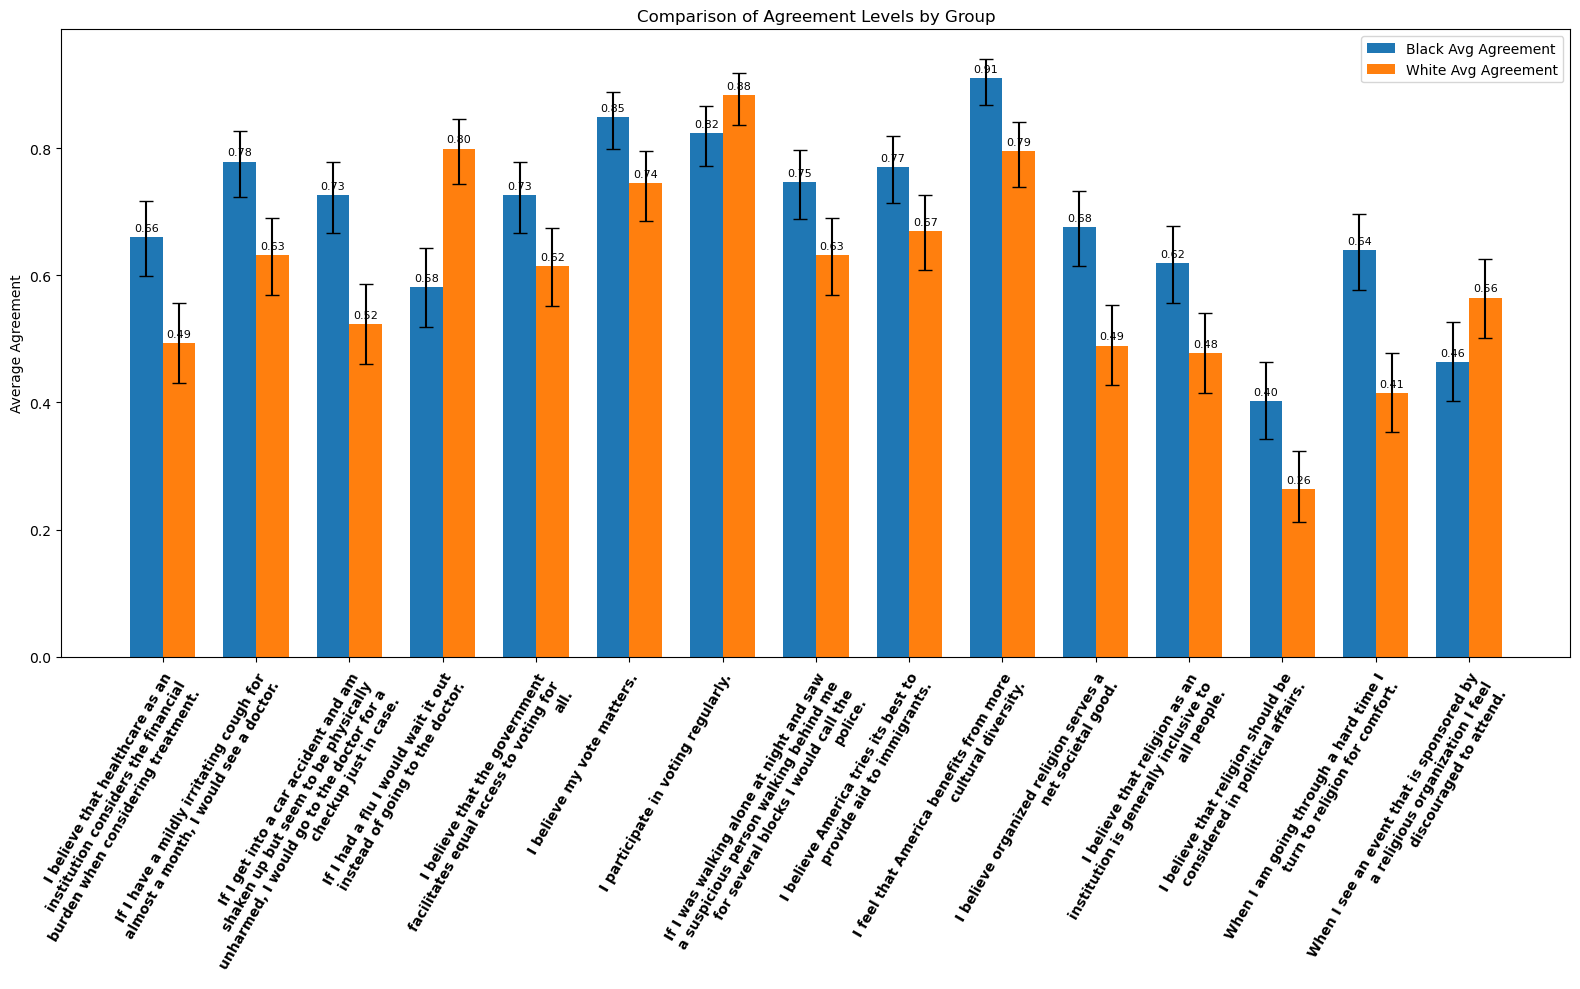

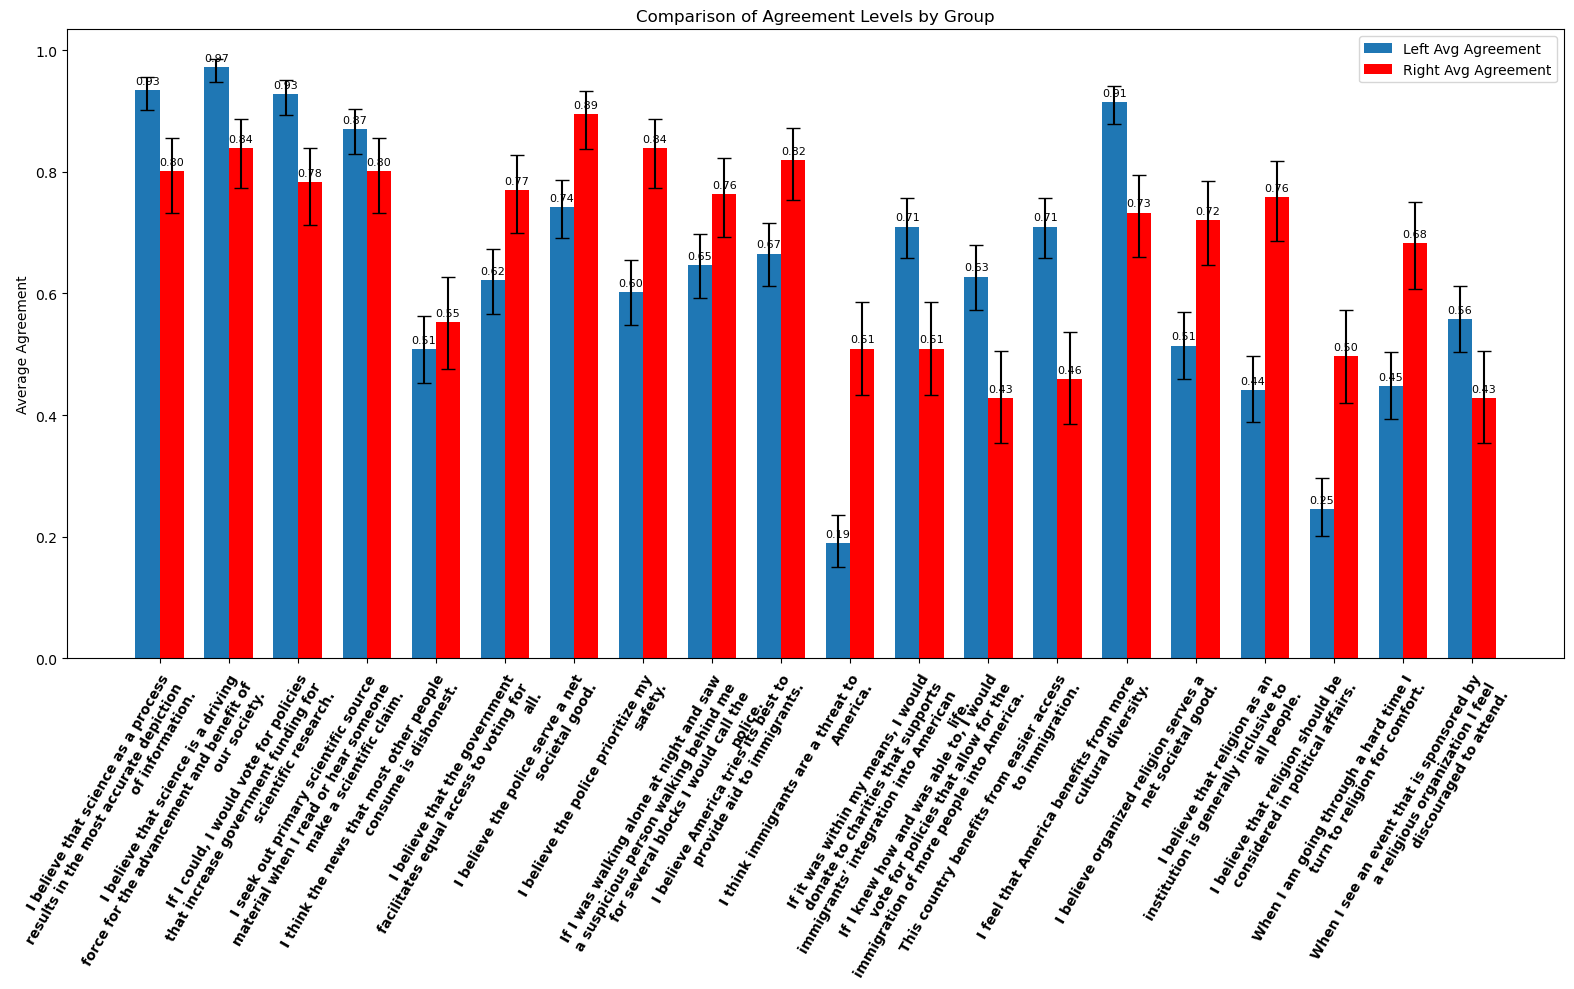

In [24]:
#@title Belief and Decision agreement differences visualizations
#Race agreement differences
data = raceMeanAgreementBD  # Assuming this is already defined and includes CI columns

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import textwrap

# Wrap function for labels
def wrap_labels(labels, width=40):
    return ['\n'.join(textwrap.wrap(label, width)) for label in labels]

# Prepare x-axis positions
x = np.arange(len(data))
width = 0.35

fig, ax = plt.subplots(figsize=(16, 10))

# Calculate error bars for BlackAvgAgreement
black_errors = np.vstack([
    data['BlackAvgAgreement'] - data['ci_lowerBlack'],
    data['ci_upperBlack'] - data['BlackAvgAgreement']
])

white_errors = np.vstack([
    data['WhiteAvgAgreement'] - data['ci_lowerWhite'],
    data['ci_upperWhite'] - data['WhiteAvgAgreement']
])

# Bar plots with error bars
bars1 = ax.bar(x - width/2, data['BlackAvgAgreement'], width, label='Black Avg Agreement',
               color='#1f77b4', yerr=black_errors, capsize=5)

bars2 = ax.bar(x + width/2, data['WhiteAvgAgreement'], width, label='White Avg Agreement',
               color='#ff7f0e', yerr=white_errors, capsize=5)  # Add error bars here if needed

# Wrapped and styled x labels
wrapped_labels = wrap_labels(data.index.tolist(), width=40)
ax.set_xticks(x)
ax.set_xticklabels(
    wrapped_labels,
    rotation=60,
    ha='right',
    fontsize=10,
    fontweight='bold',
    rotation_mode='anchor'
)

# Shift tick labels slightly right using tick_params
ax.tick_params(axis='x', pad=6)
for label in ax.get_xticklabels():
    label.set_horizontalalignment('right')
    label.set_x(label.get_position()[0] + 0.05)

# Labels and title
ax.set_ylabel('Average Agreement')
ax.set_title('Comparison of Agreement Levels by Group')
ax.legend()

# Annotate bars
def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

annotate_bars(bars1)
annotate_bars(bars2)

plt.tight_layout()
plt.show()



#News Bias agreement differences
data = newsMeanAgreementBD  # Assuming this is already defined and includes CI columns

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import textwrap

# Wrap function for labels
def wrap_labels(labels, width=40):
    return ['\n'.join(textwrap.wrap(label, width)) for label in labels]

# Prepare x-axis positions
x = np.arange(len(data))
width = 0.35

fig, ax = plt.subplots(figsize=(16, 10))

# Calculate error bars for LeftAvgAgreement
left_errors = np.vstack([
    data['LeftAvgAgreement'] - data['ci_lowerLeft'],
    data['ci_upperLeft'] - data['LeftAvgAgreement']
])

right_errors = np.vstack([
    data['RightAvgAgreement'] - data['ci_lowerRight'],
    data['ci_upperRight'] - data['RightAvgAgreement']
])

# Bar plots with error bars
bars1 = ax.bar(x - width/2, data['LeftAvgAgreement'], width, label='Left Avg Agreement',
               color='#1f77b4', yerr=left_errors, capsize=5)

bars2 = ax.bar(x + width/2, data['RightAvgAgreement'], width, label='Right Avg Agreement',
               color='red', yerr=right_errors, capsize=5)  # Add error bars here if needed

# Wrapped and styled x labels
wrapped_labels = wrap_labels(data.index.tolist(), width=40)
ax.set_xticks(x)
ax.set_xticklabels(
    wrapped_labels,
    rotation=60,
    ha='right',
    fontsize=10,
    fontweight='bold',
    rotation_mode='anchor'
)

# Shift tick labels slightly right using tick_params
ax.tick_params(axis='x', pad=6)
for label in ax.get_xticklabels():
    label.set_horizontalalignment('right')
    label.set_x(label.get_position()[0] + 0.05)

# Labels and title
ax.set_ylabel('Average Agreement')
ax.set_title('Comparison of Agreement Levels by Group')
ax.legend()

# Annotate bars
def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

annotate_bars(bars1)
annotate_bars(bars2)

plt.tight_layout()
plt.show()

In [ ]:
# @title Compute correlation between Age and "voting-joy" edge

#Generate observed
Age_VoteJoyCorr = np.corrcoef(socioDemographicData['Age_years'], PRaM_rating['voting-joy'])


# Define the permutation count and data
perm = 10000
n_samples = len(socioDemographicData['Age_years'])  # Number of samples

# Convert Age to a NumPy array for faster operations
age_array = np.array(socioDemographicData['Age_years'])

# Generate all permutations at once
pComb = np.array([np.random.permutation(n_samples) for _ in range(perm)])

# Generate all permuted versions of PrAM_final[80] in one go
yPermAll = np.array([PRaM_rating['voting-joy'].iloc[perm].to_numpy() for perm in pComb])  # Shape: (10000, 485)

# Compute correlations
age_array = age_array.reshape(1, -1)  # Shape: (1, 485) to broadcast for correlation
rPermDist = np.corrcoef(age_array, yPermAll)[0, 1:]  # Correlations between `age_array` and each row in `yPermAll`

# Convert to DataFrame
rPermDist = pd.DataFrame(rPermDist, columns=["Correlation"])

pval =[]
if Age_VoteJoyCorr[0][1] > 0:
  nBbeyond =  len(np.where(np.array(rPermDist) > Age_VoteJoyCorr[0][1])[0])
  pb = nBbeyond/perm
  pval.append(pb)
elif Age_VoteJoyCorr[0][1] < 0:
  nBbeyond = len([x for x in np.array(rPermDist) if x < Age_VoteJoyCorr[0][1]])
  pb = nBbeyond/perm
  pval.append(pb)

else:
  raise ValueError('observed beta is exactly equal to 0')

VoteJoymean = PRaM_rating['voting-joy'].mean()

print('The correlation between Age and', PairLabel[0][80],  'edge is :', round(Age_VoteJoyCorr[0][1],3), '(p=',pval,')')
print('The mean of Vote-joy is:',VoteJoymean)

The correlation between Age and voting-joy edge is : 0.087 (p= [0.0277] )
The mean of Vote-joy is: 1.556935817805383


C:\Users\rober\AppData\Local\Temp\ipykernel_6084\2620969551.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Wmat[i,j] = PairData[t]
C:\Users\rober\AppData\Local\Temp\ipykernel_6084\2620969551.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Wmat[j,i] = PairData[t]


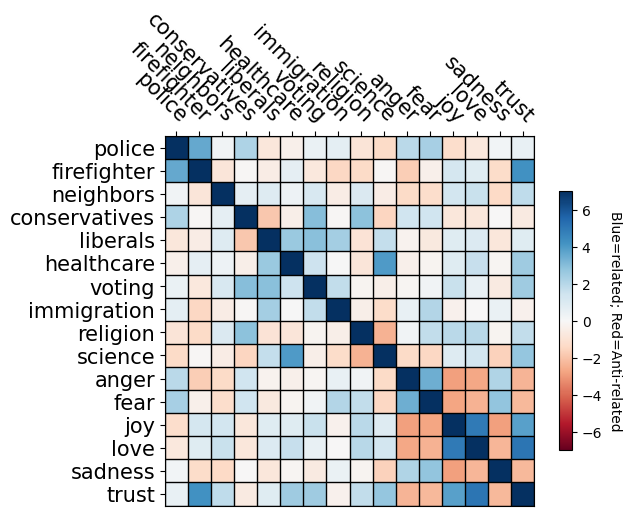

C:\Users\rober\AppData\Local\Temp\ipykernel_6084\3510774713.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  G.add_edge(conceptPairs_trim[e][0], conceptPairs_trim[e][1], weight = round(PrAM_meanEdge[e],3))


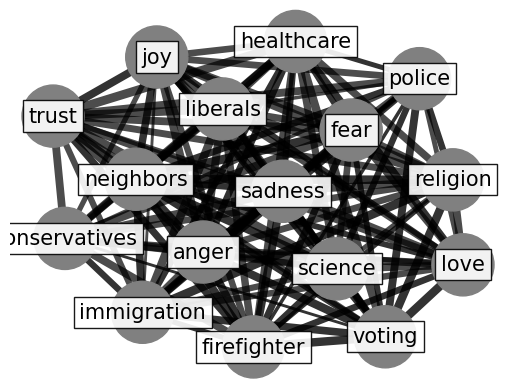

In [ ]:
# @title Figure 1 panel: (a) PRaM Schematic; (b) Heatmap of similarity ratings (c) Fully connected graph

#Create heat map of full sample [panel b]
words_trim = [re.sub("[\(].*?[\)]", "", w) for w in words]
PRaM_Weights = weightedHeatmap(avgDist, words_trim,1, '', 'Blue=related; Red=Anti-related')


#Create Fully-connected graph of associations [panel c]
PrAM_meanEdge = PRaM_edge.mean(axis=0)
#PrAM_meanEdge = (PrAM_mean - min(PrAM_mean)) / (max(PrAM_mean) - min(PrAM_mean)) #adjust range to be between 0 and 1
#PrAM_meanEdge = PrAM_meanEdge.reset_index(drop=True)
#PrAM_meanEdge = (PrAM_meanEdge + 0.01) *10 #add 0.1 to account for 0 and multiply edges by constant to aid with vizualization
conceptPairs = pd.Series(combinations_list)
conceptPairs_trim = [[re.sub("[\(].*?[\)]", "", u),re.sub("[\(].*?[\)]", "", v)] for [u,v] in conceptPairs] #remove parenthetical text from nodes for easier reading

#Identify unique and overlapping edges between race and news
sigEdge_RNoverlap = np.logical_and(sigEdges_race, sigEdges_newsBias)
sigEdge_RaceUnq = np.logical_and(sigEdges_race, ~sigEdge_RNoverlap)
sigEdge_NewsUnq = np.logical_and(sigEdges_newsBias, ~sigEdge_RNoverlap)
sigEdges = np.logical_or(sigEdge_RaceUnq, sigEdge_NewsUnq)
sigEdges = np.logical_or(sigEdges, sigEdge_RNoverlap)

#Draw Graph for average participant
G = nx.Graph()
for e in range(len(conceptPairs_trim)):
  G.add_edge(conceptPairs_trim[e][0], conceptPairs_trim[e][1], weight = round(PrAM_meanEdge[e],3))

pos = nx.spring_layout(G, iterations=10000, seed=9)  # positions for all nodes - seed for reproducibility

# Format nodes
PRaM_graphCentrality = round(pd.Series(nx.degree_centrality(G)),2) #make size of nodes proportional to centrality
nx.draw_networkx_nodes(G, pos, node_size=(PRaM_graphCentrality*2000), node_color = 'grey')
label_options = {"ec": "k", "fc": "white", "alpha": 0.9}
nx.draw_networkx_labels(G, pos, font_size=15, bbox=label_options) #ADJUST LABELS HERE

# Format edges
EdgeList = [(u,v) for (u,v) in G.edges]
EdgeList_RaceUnq = list(compress(EdgeList, sigEdge_RaceUnq))
EdgeList_NewsUnq = list(compress(EdgeList, sigEdge_NewsUnq))
EdgeList_RaceNewsOverlap = list(compress(EdgeList, sigEdge_RNoverlap))
EdgeList_nonSig = list(compress(EdgeList, ~sigEdges))

# edge width is proportional weight
edgewidth = [G.get_edge_data(u, v)["weight"] for u, v in G.edges()]
edgewidth = [(x+0.01) * 10 for x in edgewidth] #add 0.01 to account for 0 and multiply edges by constant to aid with vizualization

#Draw edges
nx.draw_networkx_edges(G, pos, edgelist=EdgeList_nonSig, width=edgewidth, alpha = 0.8) #draw all edges
nx.draw_networkx_edges(G, pos, edgelist=EdgeList_RaceUnq, width=edgewidth, alpha = 0.7)#, edge_color="b") #draw race differing edges
nx.draw_networkx_edges(G, pos, edgelist=EdgeList_NewsUnq, width=edgewidth, alpha=0.7)#, edge_color="r") #draw news differing edges
nx.draw_networkx_edges(G, pos, edgelist=EdgeList_RaceNewsOverlap, width=edgewidth, alpha=0.7)#, edge_color="purple") #draw news differing edges

#Set figure parameters
ax = plt.gca()
plt.axis("off")
#plt.title('Fully-connected graph of concept nodes and association edges')
plt.rcParams["figure.figsize"] = [8, 8]
plt.rcParams["figure.autolayout"] = True
plt.show()

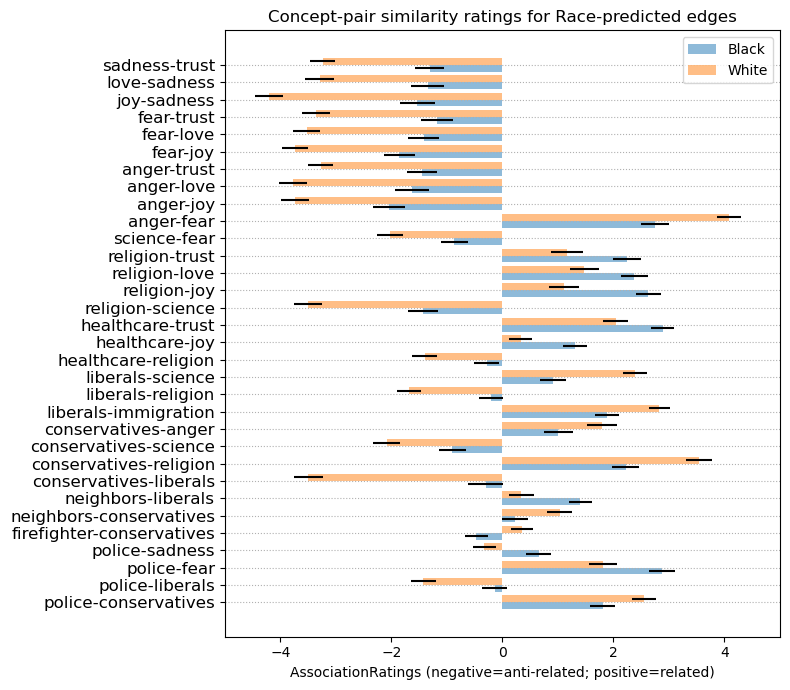

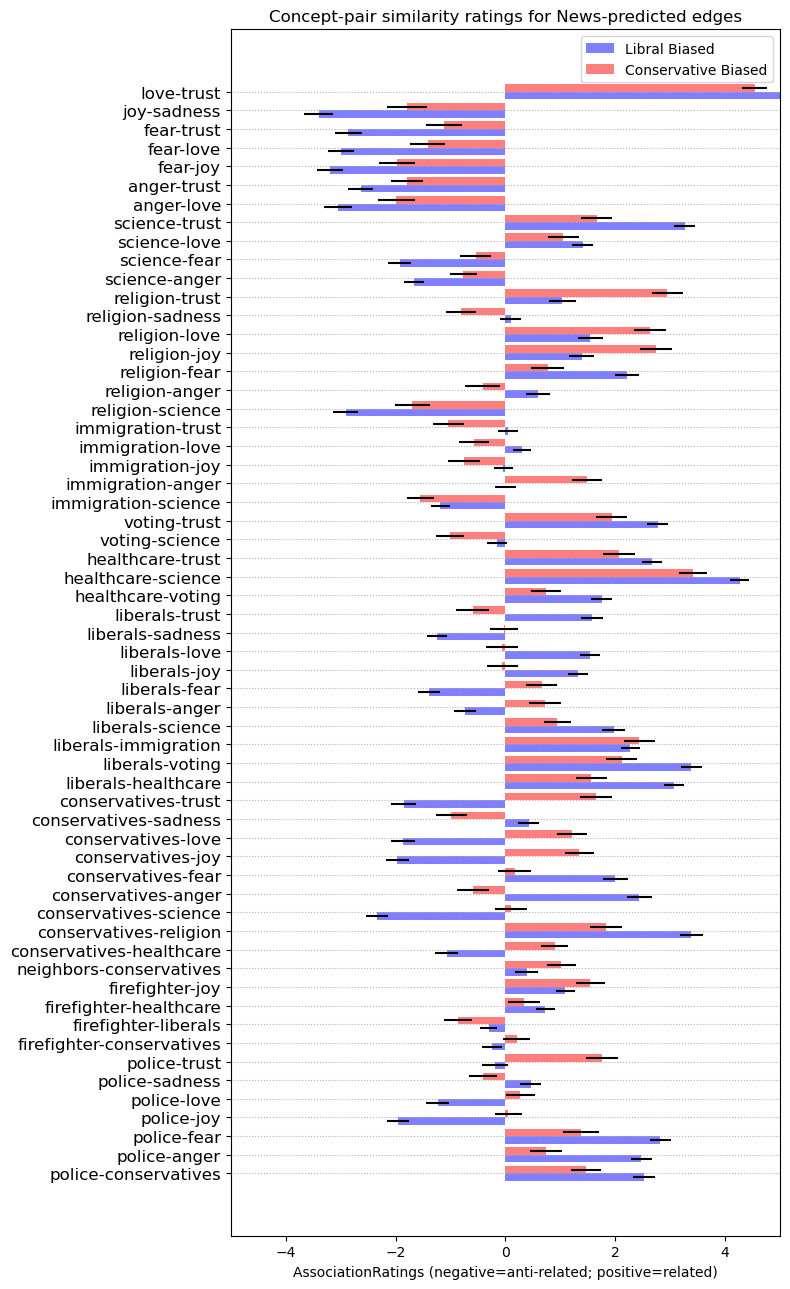

In [28]:
# @title Vizualize Concept-pair Length Comparison for Significant Edges (This will also serve as the panel for Figure 2)

# Set bar width
bar_width = 0.4

#remove parentheticals
raceEdges_trim = [re.sub("[\(].*?[\)]", "", w) for w in raceEdges[0].values.tolist()]
newsEdges_trim = [re.sub("[\(].*?[\)]", "", w) for w in newsEdges[0].values.tolist()]

# Plot grouped bar chart with error bars
plt.rcParams["figure.figsize"] = [8, 7.0]
plt.rcParams["figure.autolayout"] = True
r1_race = np.arange(len(bfsePRaM_mean))
r2_race = [x + bar_width for x in r1_race]
fig, ax_race = plt.subplots()
ax_race.barh(r1_race, bfsePRaM_mean, xerr=bfsePRaM_SEM, height=bar_width, alpha=0.5, label='Black')
ax_race.barh(r2_race, wfsePRaM_mean, xerr=wfsePRaM_SEM, height=bar_width, alpha=0.5, label='White')
plt.title('Concept-pair similarity ratings for Race-predicted edges')
ax_race.set_yticks([r + bar_width / 2 for r in range(len(bfsePRaM_mean))])
ax_race.set_yticklabels(raceEdges_trim, rotation=0, size=12)
#ax_race.grid(which = "minor", axis='y', linestyle = "dashed")
#ax_race.minorticks_on()
ax_race.set_xlabel('AssociationRatings (negative=anti-related; positive=related)')
ax_race.legend()
plt.xlim([-5, 5])
ax_race.yaxis.grid(ls = 'dotted')
plt.show()


# Plot grouped bar chart with error bars
plt.rcParams["figure.figsize"] = [8, 13.0]
plt.rcParams["figure.autolayout"] = True
r1_news = np.arange(len(lfsePRaM_mean))
r2_news = [x + bar_width for x in r1_news]
fig, ax_news = plt.subplots()
ax_news.barh(r1_news, lfsePRaM_mean, xerr=lfsePRaM_SEM, height=bar_width, alpha=0.5, label='Libral Biased', color='blue')
ax_news.barh(r2_news, rtsePRaM_mean, xerr=rtsePRaM_SEM, height=bar_width, alpha=0.5, label='Conservative Biased', color='red')
plt.title('Concept-pair similarity ratings for News-predicted edges')
ax_news.set_yticks([r + bar_width / 2 for r in range(len(lfsePRaM_mean))])
ax_news.set_yticklabels(newsEdges_trim, rotation=0, size = 12)
ax_news.set_xlabel('AssociationRatings (negative=anti-related; positive=related)')
ax_news.legend()
plt.xlim([-5, 5])
ax_news.yaxis.grid(ls = 'dotted')
plt.show()

In [ ]:
# @title Paper-relevant descriptive statistics
pd.set_option('mode.chained_assignment', None)
#Using data defined above
  # lfsePRaM_mean = lfPRaM_sigEdges.mean(axis=0)
  # rtsePRaM_mean = rtPRaM_sigEdges.mean(axis=0)
  # lfsePRaM_SEM = np.std(lfPRaM_sigEdges, axis=0)/np.sqrt(lfPRaM_sigEdges.shape[0])
  # rtsePRaM_SEM = np.std(rtPRaM_sigEdges, axis=0)/np.sqrt(rtPRaM_sigEdges.shape[0])

#Create data frame of labels, policital means, and SEM
newsDiffRatings = pd.DataFrame()
newsDiffRatings['LeftRatings'] = lfsePRaM_mean
newsDiffRatings['RightRatings'] = rtsePRaM_mean
newsDiffRatings['LeftSEM'] = lfsePRaM_SEM
newsDiffRatings['RightSEM'] = rtsePRaM_SEM

display(newsDiffRatings)


raceDiffRatings = pd.DataFrame()
raceDiffRatings['BlackRatings'] = bfsePRaM_mean
raceDiffRatings['WhiteRatings'] = wfsePRaM_mean
raceDiffRatings['BlackSEM'] = bfsePRaM_SEM
raceDiffRatings['WhiteSEM'] = wfsePRaM_SEM
display(raceDiffRatings)

,LeftRatings,RightRatings,LeftSEM,RightSEM
police-conservatives(political),2.523659,1.465839,0.195713,0.266145
police-anger,2.476341,0.739130,0.196879,0.289006
police-fear,2.823344,1.372671,0.198465,0.323557
police-joy,-1.955836,0.055901,0.204911,0.252031
police-love,-1.233438,0.273292,0.204555,0.258938
police-sadness,0.457413,-0.403727,0.195448,0.257652
police-trust,-0.195584,1.751553,0.239371,0.289608
firefighter-conservatives(political),-0.246057,0.204969,0.176397,0.245969
firefighter-liberals(political),-0.305994,-0.863354,0.161079,0.252375
firefighter-healthcare,0.725552,0.341615,0.175784,0.289751


,BlackRatings,WhiteRatings,BlackSEM,WhiteSEM
police-conservatives(political),1.807377,2.552301,0.225296,0.219380
police-liberals(political),-0.139344,-1.422594,0.222192,0.220860
police-fear,2.877049,1.811715,0.235301,0.247058
police-sadness,0.655738,-0.322176,0.228888,0.207701
firefighter-conservatives(political),-0.467213,0.355649,0.201893,0.199822
neighbors(yours)-conservatives(political),0.233607,1.033473,0.233271,0.226859
neighbors(yours)-liberals(political),1.405738,0.338912,0.213226,0.225614
conservatives(political)-liberals(political),-0.303279,-3.493724,0.321128,0.262225
conservatives(political)-religion,2.225410,3.543933,0.242483,0.229069
conservatives(political)-science,-0.901639,-2.083682,0.242103,0.246270


In [ ]:
socioDemographicData['NewsBiasQuant'] = pd.to_numeric(socioDemographicData['NewsBiasQuant'], errors='coerce')
cols_to_numeric = ['NewsBiasQuant', 'Black or African American', 'FemaleGender', 'IncomeOrdinal', 'Age_years', 'EducationOrdinal']
socioDemographicData[cols_to_numeric] = socioDemographicData[cols_to_numeric].apply(pd.to_numeric, errors='coerce')


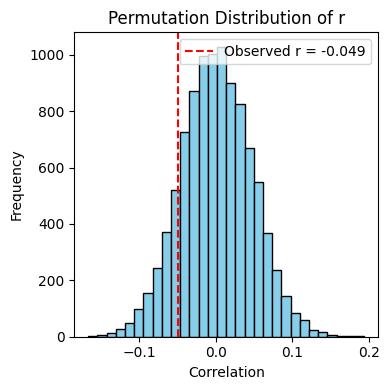

The r between Black identity and conservative news consumption is: -0.049 (p = 0.1344)


In [ ]:
obsCorr_BN = np.corrcoef(socioDemographicData['NewsBiasQuant'], socioDemographicData['Black or African American'])
observed_r = obsCorr_BN[0, 1]

# Permutation settings
perm = 10000
n_samples = len(socioDemographicData)

# Convert data to arrays
news_array = np.array(socioDemographicData['NewsBiasQuant'])
blackCoded = np.array(socioDemographicData['Black or African American'])

# Generate permutations of the racial identity variable
pComb = np.array([np.random.permutation(n_samples) for _ in range(perm)])
yPermAll = np.array([blackCoded[perm_idx] for perm_idx in pComb])  # shape: (perm, n_samples)

# Compute correlations for each permutation
rPermDist = np.array([np.corrcoef(news_array, y_perm)[0, 1] for y_perm in yPermAll])

# Convert to DataFrame
rPermDF = pd.DataFrame(rPermDist, columns=["Correlation"])

# Compute two-tailed p-value (for more robustness)
if observed_r > 0:
    n_extreme = np.sum(rPermDist >= observed_r)
elif observed_r < 0:
    n_extreme = np.sum(rPermDist <= observed_r)
else:
    raise ValueError("Observed correlation is exactly zero.")

pval = n_extreme / perm

# Plot histogram
plt.rcParams["figure.figsize"] = [4, 4]
plt.rcParams["figure.autolayout"] = True
plt.hist(rPermDist, bins=30, color='skyblue', edgecolor='black')
plt.axvline(x=observed_r, color='red', linestyle='--', label=f'Observed r = {round(observed_r, 3)}')
plt.title("Permutation Distribution of r")
plt.xlabel("Correlation")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Print result
print(f'The r between Black identity and conservative news consumption is: {round(observed_r, 3)} (p = {pval:.4f})')


In [ ]:
# @title Measure non-Race identity variables with News consumption [Something is weird with AGEDF and NewsBias_Cor]

#Compute Age correlation permutation
obsCorr_AN = np.corrcoef(Age, NewsBias)
print('Age/NewsConsumption r = ', obsCorr_AN[0][1])

# Define the permutation count and data
perm = 10000
n_samples = len(NewsBias)  # Number of samples

age_array = np.array(Age) # Convert Age to a NumPy array for faster operations
pComb = np.array([np.random.permutation(n_samples) for _ in range(perm)]) # Generate all permutations at once
yPermAll = np.array([NewsBias[perm] for perm in pComb])  # Shape: (10000, 485) # Generate all permuted versions in one go
age_array = age_array.reshape(1, -1)  # Shape: (1, 485) to broadcast for correlation
rPermDist = np.corrcoef(age_array, yPermAll)[0, 1:]  # Correlations between `age_array` and each row in `yPermAll`
rPermDist = pd.DataFrame(rPermDist, columns=["Correlation"]) # Convert to DataFrame

pval =[]
if obsCorr_AN[0][1] > 0:
  nBbeyond =  len(np.where(np.array(rPermDist) > obsCorr_AN[0][1])[0])
  pb = nBbeyond/perm
  pval.append(pb)
elif obsCorr_AN[0][1] < 0:
  nBbeyond = len([x for x in np.array(rPermDist) if x < obsCorr_AN[0][1]])
  pb = nBbeyond/perm
  pval.append(pb)
else:
  raise ValueError('observed beta is exactly equal to 0')
print('  Age/NewsConsumption p-value = ', pval)


#Compute Income correlation permutation
Income_nGnANB_array = Income_nGnANB.to_numpy().squeeze()
Income_nGnANB_array = np.asarray(Income_nGnANB_array, dtype=np.float64)
obsCorr_IN = np.corrcoef(Income_nGnANB_array, NewsBias)
print('Income/NewsConsumption r = ', obsCorr_IN[0][1])

income_array = np.array(Income_nGnANB_array) # Convert Income to a NumPy array for faster operations
pComb = np.array([np.random.permutation(n_samples) for _ in range(perm)]) # Generate all permutations at once
yPermAll = np.array([NewsBias[perm] for perm in pComb])  # Shape: (10000, 485) # Generate all permuted versions in one go
income_array = income_array.reshape(1, -1)  # Shape: (1, 485) to broadcast for correlation
rPermDist = np.corrcoef(income_array, yPermAll)[0, 1:]  # Correlations between `income_array` and each row in `yPermAll`
rPermDist = pd.DataFrame(rPermDist, columns=["Correlation"]) # Convert to DataFrame

pval =[]
if obsCorr_IN[0][1] > 0:
  nBbeyond =  len(np.where(np.array(rPermDist) > obsCorr_IN[0][1])[0])
  pb = nBbeyond/perm
  pval.append(pb)
elif obsCorr_IN[0][1] < 0:
  nBbeyond = len([x for x in np.array(rPermDist) if x < obsCorr_IN[0][1]])
  pb = nBbeyond/perm
  pval.append(pb)
else:
  raise ValueError('observed beta is exactly equal to 0')
print('  Income/NewsConsumption p-value = ', pval)


#Compute Gender correlation permutation
Gender_nGnANB_array = Gender_nGnANB.to_numpy().squeeze()
Gender_nGnANB_array = np.asarray(Gender_nGnANB_array, dtype=np.float64)
obsCorr_GN = np.corrcoef(Gender_nGnANB_array, NewsBias)
print('Gender/NewsConsumption r = ', obsCorr_GN[0][1])

gender_array = np.array(Gender_nGnANB_array) # Convert Income to a NumPy array for faster operations
pComb = np.array([np.random.permutation(n_samples) for _ in range(perm)]) # Generate all permutations at once
yPermAll = np.array([NewsBias[perm] for perm in pComb])  # Shape: (10000, 485) # Generate all permuted versions in one go
gender_array = gender_array.reshape(1, -1)  # Shape: (1, 485) to broadcast for correlation
rPermDist = np.corrcoef(gender_array, yPermAll)[0, 1:]  # Correlations between `gender_array` and each row in `yPermAll`
rPermDist = pd.DataFrame(rPermDist, columns=["Correlation"]) # Convert to DataFrame

pval =[]
if obsCorr_GN[0][1] > 0:
  nBbeyond =  len(np.where(np.array(rPermDist) > obsCorr_GN[0][1])[0])
  pb = nBbeyond/perm
  pval.append(pb)
elif obsCorr_GN[0][1] < 0:
  nBbeyond = len([x for x in np.array(rPermDist) if x < obsCorr_GN[0][1]])
  pb = nBbeyond/perm
  pval.append(pb)
else:
  raise ValueError('observed beta is exactly equal to 0')
print('  Gender/NewsConsumption p-value = ', pval)

NameError: name 'Age' is not defined

In [ ]:
# @title Mediation analysis measuring effect of Black Identity (X) on Pair-distances (Yi) through News Consumption Bias (m)
warnings.filterwarnings('ignore')

#Use 10,000 iteration output (1 = yes; 0 = no)
use10000iter = 1

#Subset Mediation analysis by sig edges
PRaM_sigNewsEdges = PrAM_final.loc[:,sigEdges_newsBias]

#X: Black Identity
X_med = blackCoded.reshape(blackCoded.shape[0]) #adjust shape to fit

#m: News Consumption Bias
m_med = NewsBias

#Y: Pair data
Y_med = PRaM_sigNewsEdges.to_numpy()

#Loop through each pair and compute a permutation scrambling Y
ObsPairsPRaM_med = pd.DataFrame({'TotEff':[],'MedEff':[], 'DirEff':[], 'SumEff':[], 'SobelT':[]})
pPairsPRaM_med = pd.DataFrame({'Totpval':[],'Medpval':[], 'Dirpval':[], 'Sumpval':[], 'SobelTpval':[]})
perm = 10
#Iterate through concept-pairs
for i in tqdm(range(Y_med.shape[1])):
  # Isolate pair data
  yi = Y_med[:,i]
  #Dummy coded linear regression
  #Compared against permuted distribution
  medObs_PRaM, pval_PRaM = mediationPerm_v2(X_med, m_med, yi, perm)

  #Update output
  ObsPairsPRaM_med = pd.concat([ObsPairsPRaM_med,medObs_PRaM],ignore_index=True)
  pPairsPRaM_med = pd.concat([pPairsPRaM_med, pval_PRaM],ignore_index=True)

#Implement FDR correction

FDR_sigMed = []
import statsmodels as sm
for columnName, columnData in pPairsPRaM_med.items():
  FDR = sm.stats.multitest.fdrcorrection(columnData, alpha=0.05, method='indep', is_sorted=False)
  FDR_sigMed.append(FDR[0])
FDR_sigMed = pd.DataFrame(FDR_sigMed)

#Export data to CSV files
if use10000iter == 0:
  PrAM_save = pd.DataFrame(PRaM_nGnANB)
  FDR_sigMed.to_csv('FDRsigMed.csv')
  pPairsPRaM_med.to_csv('pPairsPRaM_med.csv')
  ObsPairsPRaM_med.to_csv('ObsPairsPRaM_med.csv')
  PrAM_save.to_csv('PRaM_finalModel_med.csv')
elif use10000iter == 1:
  FDR_sigMed = pd.read_csv (path + 'analysis/FDRsigMed_Ordinal_100000.csv', header=0, index_col=0)
  pPairsPRaM_med = pd.read_csv (path + 'analysis/pPairsPRaM_med_Ordinal_100000.csv', header=0, index_col=0)
  ObsPairsPRaM_med = pd.read_csv (path + 'analysis/ObsPairsPRaM_med_Ordinal_100000.csv', header=0, index_col=0)
  #PrAM_final = pd.read_csv (path + 'analysis/PRaM_finalModel_med_10000.csv', header=0, index_col=0)
  #PrAM_final = pd.DataFrame(PRaM_nGnANB)

NameError: name 'PrAM_final' is not defined

In [ ]:
PRaM_sigNewsEdges = PrAM_final.loc[:, sigEdges_newsBias]

# X (predictor): Black Identity, reshape to 1D
X_med = blackCoded.reshape(-1)

# M (mediator): News Consumption Bias
m_med = NewsBias

# Y (outcome): pair distances for each edge as numpy array
Y_med = PRaM_sigNewsEdges.to_numpy()

# Initialize empty DataFrames to collect results
ObsPairsPRaM_med = pd.DataFrame(columns=['TotEff', 'MedEff', 'DirEff', 'SumEff', 'SobelT'])
pPairsPRaM_med = pd.DataFrame(columns=['Totpval', 'Medpval', 'Dirpval', 'Sumpval', 'SobelTpval'])

# Number of permutations for the permutation test (increase for better accuracy)
perm = 1000

# Loop over each concept-pair edge (each column in Y_med)
for i in tqdm(range(Y_med.shape[1])):
    yi = Y_med[:, i]

    # Run your mediation permutation function (make sure this is defined in your environment)
    medObs_PRaM, pval_PRaM = mediationPerm_v2(X_med, m_med, yi, perm)

    # Append results
    ObsPairsPRaM_med = pd.concat([ObsPairsPRaM_med, medObs_PRaM], ignore_index=True)
    pPairsPRaM_med = pd.concat([pPairsPRaM_med, pval_PRaM], ignore_index=True)

# OPTIONAL: Apply FDR correction on p-values
import statsmodels.api as sm

FDR_sigMed = []
for columnName in pPairsPRaM_med.columns:
    _, sig = sm.stats.multitest.fdrcorrection(pPairsPRaM_med[columnName], alpha=0.05)
    FDR_sigMed.append(sig)

FDR_sigMed = pd.DataFrame(FDR_sigMed, index=pPairsPRaM_med.columns).transpose()

# Now ObsPairsPRaM_med, pPairsPRaM_med, and FDR_sigMed have your mediation results

print("Mediation analysis complete!")


NameError: name 'PrAM_final' is not defined

In [ ]:
# @title Figure 2: Group diff. Panel (a) Graph with racediffering edges. (b)bar graph (c) black graph (d) white graph

PrAM_final_reverse = (1 - PrAM_final)*2 #Reverse direction because networkx weights are such that high values meen shroter edges
seedn = 9
#Panel (a): Draw Graph for average participant
PrAM_finalRaceEdges = PrAM_final_reverse.loc[:,sigEdges_race] #This is in edge space
PrAM_meanRaceEdge = PrAM_finalRaceEdges.mean(axis=0)
PrAM_meanRaceEdge = PrAM_meanRaceEdge.reset_index(drop=True)

conceptPairs_race = pd.Series(list(compress(conceptPairs, sigEdges_race)))
conceptPairs_race = conceptPairs_race.reset_index(drop=True)
conceptPairsRace_trim = [[re.sub("[\(].*?[\)]", "", u),re.sub("[\(].*?[\)]", "", v)] for [u,v] in conceptPairs_race] #remove parenthetical text from nodes for easier reading


#Generate index of betas to reflect direction
raceBetas = bObsPairsPRaM['1']
raceBetas = raceBetas.loc[sigEdges_race]
raceBetas = raceBetas.reset_index(drop=True)
raceEdges_posBetas = raceBetas > 0 #Going from 0(white) to 1(black) results in an increase in edge distance
raceEdges_negBetas = raceBetas < 0 #Going from 0(white) to 1(black) results in an decrease in edge distance


G = nx.Graph()
for e in range(len(conceptPairsRace_trim)):
  G.add_edge(conceptPairsRace_trim[e][0], conceptPairsRace_trim[e][1], weight = round(PrAM_meanRaceEdge[e],3))

pos = nx.spring_layout(G, iterations=10000, seed=seedn)  # positions for all nodes - seed for reproducibility

# Format nodes
PRaM_graphCentrality = round(pd.Series(nx.degree_centrality(G)),2) #make size of nodes proportional to centrality
print('Graph Centrality')
print(PRaM_graphCentrality)
nx.draw_networkx_nodes(G, pos, node_size=(PRaM_graphCentrality*2000), node_color = 'black', alpha= 0.7)
label_options = {"ec": "k", "fc": "white", "alpha": 0.9}
nx.draw_networkx_labels(G, pos, font_size=15, bbox=label_options)

# Format edges
EdgeList = [(u,v) for (u,v) in G.edges]
EdgeList_posBeta = list(compress(EdgeList, raceEdges_posBetas))
EdgeList_negBeta = list(compress(EdgeList, raceEdges_negBetas))


# edge width is proportional weight
edgewidth = [G.get_edge_data(u, v)["weight"] for u, v in G.edges()]
edgewidth = [(x+0.01) * 5 for x in edgewidth] #add 0.01 to account for 0 and multiply edges by constant to aid with vizualization

#Draw edges
nx.draw_networkx_edges(G, pos, edgelist=EdgeList_posBeta, width=edgewidth, alpha = 0.5, edge_color="r") #draw race differing edges
nx.draw_networkx_edges(G, pos, edgelist=EdgeList_negBeta, width=edgewidth, alpha= 0.5, edge_color="b") #draw news differing edges

#Set figure parameters
ax = plt.gca()
plt.axis("off")
#plt.title('Fully-connected graph of concept nodes and association edges')
plt.rcParams["figure.figsize"] = [7, 7]
plt.rcParams["figure.autolayout"] = True
plt.show()


#Panel (b): Use table of mean similarity differences by race-differing edges


#Panel (c): Same as a except use Black participant edges instead of group
PrAM_RaceEdges_blackp = PrAM_final_reverse.loc[bfIdx,sigEdges_race] #This is in edge space
PrAM_meanRaceEdges_blackp = PrAM_RaceEdges_blackp.mean(axis=0)
PrAM_meanRaceEdges_blackp = PrAM_meanRaceEdges_blackp.reset_index(drop=True)

G = nx.Graph()
for e in range(len(conceptPairsRace_trim)):
  G.add_edge(conceptPairsRace_trim[e][0], conceptPairsRace_trim[e][1], weight = round(PrAM_meanRaceEdges_blackp[e],3))

pos = nx.spring_layout(G, iterations=10000, seed=seedn)  # positions for all nodes - seed for reproducibility

# Format nodes
PRaM_graphCentrality = round(pd.Series(nx.degree_centrality(G)),2) #make size of nodes proportional to centrality
nx.draw_networkx_nodes(G, pos, node_size=(PRaM_graphCentrality*2000), node_color = 'black', alpha= 0.7)
label_options = {"ec": "k", "fc": "white", "alpha": 0.9}
nx.draw_networkx_labels(G, pos, font_size=15, bbox=label_options)

# Format edges
EdgeList = [(u,v) for (u,v) in G.edges]

# edge width is proportional weight
edgewidth = [G.get_edge_data(u, v)["weight"] for u, v in G.edges()]
edgewidth = [(x+0.01) * 5 for x in edgewidth] #add 0.01 to account for 0 and multiply edges by constant to aid with vizualization

#Draw edges
nx.draw_networkx_edges(G, pos, edgelist=EdgeList, width=edgewidth, alpha = 0.5, edge_color="black") #draw race differing edges

#Set figure parameters
ax = plt.gca()
plt.axis("off")
#plt.title('Fully-connected graph of concept nodes and association edges')
plt.rcParams["figure.figsize"] = [7, 7]
plt.rcParams["figure.autolayout"] = True
plt.show()

#Panel (d): Graph of white partiicpants
PrAM_RaceEdges_whitep = PrAM_final_reverse.loc[wfIdx,sigEdges_race] #This is in edge space
PrAM_meanRaceEdges_whitep = PrAM_RaceEdges_whitep.mean(axis=0)
PrAM_meanRaceEdges_whitep = PrAM_meanRaceEdges_whitep.reset_index(drop=True)

G = nx.Graph()
for e in range(len(conceptPairsRace_trim)):
  G.add_edge(conceptPairsRace_trim[e][0], conceptPairsRace_trim[e][1], weight = round(PrAM_meanRaceEdges_whitep[e],3))

pos = nx.spring_layout(G, iterations=10000, seed=seedn)  # positions for all nodes - seed for reproducibility

# Format nodes
PRaM_graphCentrality = round(pd.Series(nx.degree_centrality(G)),2) #make size of nodes proportional to centrality
nx.draw_networkx_nodes(G, pos, node_size=(PRaM_graphCentrality*2000), node_color = 'black', alpha= 0.7)
label_options = {"ec": "k", "fc": "white", "alpha": 0.9}
nx.draw_networkx_labels(G, pos, font_size=12, bbox=label_options)

# Format edges
EdgeList = [(u,v) for (u,v) in G.edges]

# edge width is proportional weight
edgewidth = [G.get_edge_data(u, v)["weight"] for u, v in G.edges()]
edgewidth = [(x+0.01) * 5 for x in edgewidth] #add 0.01 to account for 0 and multiply edges by constant to aid with vizualization

#Draw edges
nx.draw_networkx_edges(G, pos, edgelist=EdgeList, width=edgewidth, alpha = 0.5, edge_color="black") #draw race differing edges

#Set figure parameters
ax = plt.gca()
plt.axis("off")
#plt.title('Fully-connected graph of concept nodes and association edges')
plt.rcParams["figure.figsize"] = [7, 7]
plt.rcParams["figure.autolayout"] = True
plt.show()



NameError: name 'PrAM_final' is not defined

In [ ]:
## Nicer Graphs

seedn = 9
plt.rcParams["figure.figsize"] = [7, 7]
plt.rcParams["figure.autolayout"] = True

def clean_node_label(label):
    """Remove parenthetical text from node labels for easier reading."""
    return re.sub(r"\(.*?\)", "", label).strip()

def build_graph(edge_weights, concept_pairs, weights_round=3):
    """Create a NetworkX graph from edge weights and concept pairs."""
    G = nx.Graph()
    for i, (u, v) in enumerate(concept_pairs):
        G.add_edge(clean_node_label(u), clean_node_label(v), weight=round(edge_weights[i], weights_round))
    return G

def draw_graph(G, pos, edge_colors=None, edge_alphas=None, node_size_factor=2000, node_color='black', edge_width_scale=5, label_fontsize=15):
    """Draw the graph with node sizes proportional to degree centrality and optional colored edges."""
    centrality = nx.degree_centrality(G)
    node_sizes = [v * node_size_factor for v in centrality.values()]

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_color, alpha=0.7)

    # Draw labels with white background
    label_opts = {"ec": "k", "fc": "white", "alpha": 0.9}
    nx.draw_networkx_labels(G, pos, font_size=label_fontsize, bbox=label_opts)

    # Draw edges
    if edge_colors is None:
        # Draw all edges black if no color specified
        edge_colors = ['black'] * len(G.edges)
    if edge_alphas is None:
        edge_alphas = [0.5] * len(G.edges)

    edge_widths = [(G[u][v]['weight'] + 0.01) * edge_width_scale for u, v in G.edges]

    # Draw edges one by one to assign alpha
    ax = plt.gca()
    for (u, v), w, c, a in zip(G.edges, edge_widths, edge_colors, edge_alphas):
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=w, alpha=a, edge_color=c)

    plt.axis('off')
    plt.show()

# --- Prepare data for panel (a): average participant graph with race-differing edges ---

PrAM_finalRaceEdges = PrAM_final_reverse.loc[:, sigEdges_race]
PrAM_meanRaceEdge = PrAM_finalRaceEdges.mean(axis=0).reset_index(drop=True)

conceptPairs_race = pd.Series(list(compress(conceptPairs, sigEdges_race))).reset_index(drop=True)
conceptPairsRace_trim = [(clean_node_label(u), clean_node_label(v)) for u, v in conceptPairs_race]

raceBetas = bObsPairsPRaM['1'].loc[sigEdges_race].reset_index(drop=True)
raceEdges_posBetas = raceBetas > 0
raceEdges_negBetas = raceBetas < 0

G = build_graph(PrAM_meanRaceEdge, conceptPairsRace_trim)
pos = nx.spring_layout(G, iterations=10000, seed=seedn)

# Prepare edge color lists for positive and negative betas
edges_list = list(G.edges)
edge_colors = []
edge_alphas = []

for idx, edge in enumerate(edges_list):
    if raceEdges_posBetas.iloc[idx]:
        edge_colors.append('red')
        edge_alphas.append(0.5)
    elif raceEdges_negBetas.iloc[idx]:
        edge_colors.append('blue')
        edge_alphas.append(0.5)
    else:
        edge_colors.append('grey')
        edge_alphas.append(0.2)

draw_graph(G, pos, edge_colors=edge_colors, edge_alphas=edge_alphas)

# --- Panel (c): Black participant graph ---

PrAM_RaceEdges_blackp = PrAM_final_reverse.loc[bfIdx, sigEdges_race]
PrAM_meanRaceEdges_blackp = PrAM_RaceEdges_blackp.mean(axis=0).reset_index(drop=True)

G_black = build_graph(PrAM_meanRaceEdges_blackp, conceptPairsRace_trim)
pos_black = nx.spring_layout(G_black, iterations=10000, seed=seedn)

draw_graph(G_black, pos_black, node_color='black')

# --- Panel (d): White participant graph ---

PrAM_RaceEdges_whitep = PrAM_final_reverse.loc[wfIdx, sigEdges_race]
PrAM_meanRaceEdges_whitep = PrAM_RaceEdges_whitep.mean(axis=0).reset_index(drop=True)

G_white = build_graph(PrAM_meanRaceEdges_whitep, conceptPairsRace_trim)
pos_white = nx.spring_layout(G_white, iterations=10000, seed=seedn)

draw_graph(G_white, pos_white, node_color='black', label_fontsize=12)


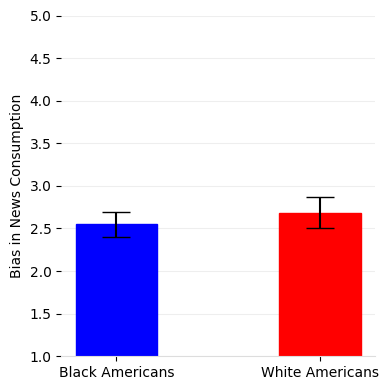

mean black news bias  2.55
mean white news bias  2.68
99CI black news bias  0.14
99CI white news bias  0.18
mean black news bias plus 1 CI(99%) is 2.69
mean white news bias minus 1 CI(99%) is 2.5
Graph Centrality
police           0.15
conservatives    0.46
sadness          0.15
firefighter      0.08
neighbors        0.08
religion         0.38
science          0.31
anger            0.15
liberals         0.15
immigration      0.08
joy              0.23
love             0.15
trust            0.23
fear             0.31
dtype: float64


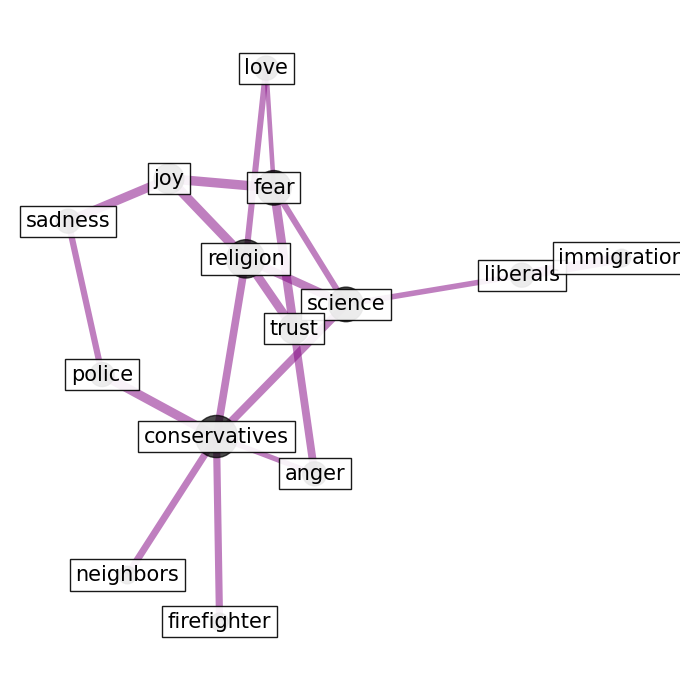

Graph Centrality
police           0.21
conservatives    0.50
liberals         0.43
sadness          0.29
firefighter      0.07
neighbors        0.14
religion         0.50
science          0.29
anger            0.36
immigration      0.07
healthcare       0.21
joy              0.36
trust            0.36
love             0.29
fear             0.36
dtype: float64


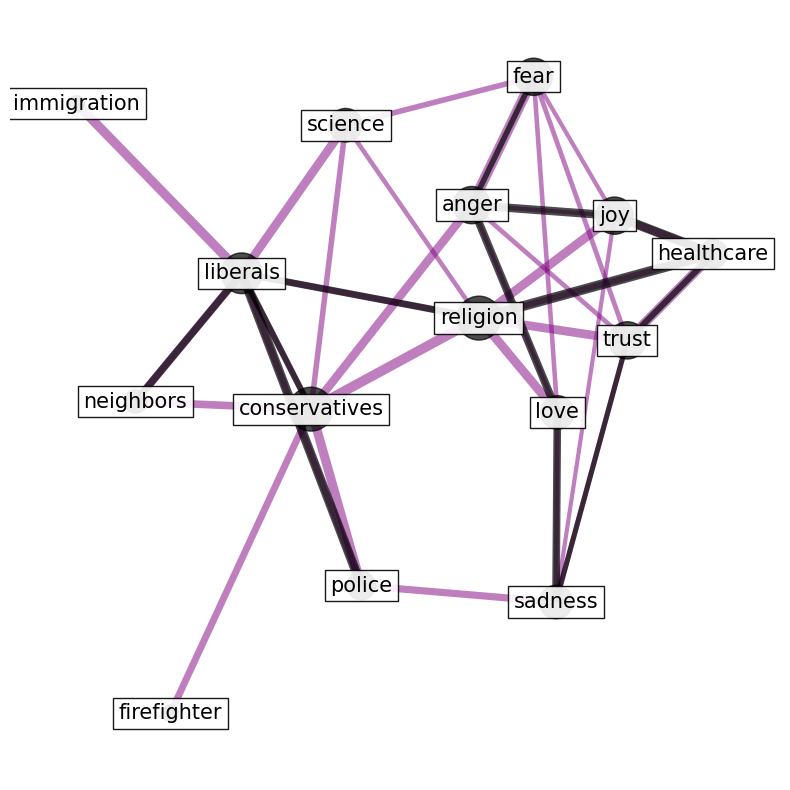

In [ ]:
# @title Figure 4: News bias diff Panel (a) Histogram of news bias both and individual racial groups. (b)bar graph showing mean and sd diff. (c) subgraph "Information" (indirect effects; ab[i.e., just mediated relationships]). (d) subgraph "Experience" (direct; c')


# Panel(a): histogram of political bias ratings



#Panel (b): Bar plot of political bias by group
bNewsBias = NewsBias_nGnANB[bIndx_nGnANB]
wNewsBias = NewsBias_nGnANB[wIndx_nGnANB]

bNewsBias_mean = bNewsBias.mean()
wNewsBias_mean = wNewsBias.mean()
bNewsBias_std = bNewsBias.std()
wNewsBias_std = wNewsBias.std()

bNewsBias_99CI = 	2.576*(bNewsBias_std/np.sqrt(len(bNewsBias)))
wNewsBias_99CI = 	2.576*(wNewsBias_std/np.sqrt(len(wNewsBias)))

barDat = {'Black Americans':bNewsBias_mean, 'White Americans':wNewsBias_mean}
groups = list(barDat.keys())
meanBias = list(barDat.values())
barSD = [bNewsBias_99CI, wNewsBias_99CI]

fig, ax = plt.subplots(figsize = (4, 4))
# xtick_loc = [1, 1.5]
# ax.set_xticks(xtick_loc)
bars = plt.bar(groups, meanBias, yerr=barSD, width = 0.4, capsize=10)
bars[0].set_color('b')
bars[1].set_color('r')
plt.ylim(1,5)
plt.ylabel("Bias in News Consumption")
plt.xticks
#plt.errorbar(fmt='o', markersize=8, capsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')

ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
plt.show()

print('mean black news bias ', round(bNewsBias_mean,2))
print('mean white news bias ', round(wNewsBias_mean,2))
print('99CI black news bias ', round(bNewsBias_99CI,2))
print('99CI white news bias ', round(wNewsBias_99CI,2))
print('mean black news bias plus 1 CI(99%) is', round(bNewsBias_mean+bNewsBias_99CI,2))
print('mean white news bias minus 1 CI(99%) is', round(wNewsBias_mean-wNewsBias_99CI,2))


#Panel (c): Subgraph of mediated effects !!!!!!!!!!!!!!!
PrAM_meanRaceEdge = PrAM_meanRaceEdge #Reversed (i.e. 1-OG edges) to be formatted for network x

#Get Booleans of Med and Direct effects
FDR_sigMedT = FDR_sigMed.transpose()
sigMediation = FDR_sigMedT[1]
sigDirect = FDR_sigMedT[2]
sigDirMed = pd.Series(list(compress(sigDirect, sigMediation)))
sigDirectUnq = pd.Series(list(compress(sigDirect, ~sigMediation)))
sigMediationUnq = pd.Series(list(compress(~sigDirMed, sigMediation)))

#Get full-set indicies of dir, med, and dir/med effects
newsSigIndex = [i for i, x in enumerate(sigEdges_newsBias) if x]
newsSigIndex_dir = list(compress(newsSigIndex, sigDirect))
newsSigIndex_med = list(compress(newsSigIndex, sigMediation))
newsSigIndex_dirMed = list(compress(newsSigIndex, sigDirMed))
newsSigIndex_dirUnq = list(compress(newsSigIndex, sigDirectUnq))
newsSigIndex_medUnq = list(compress(newsSigIndex, sigMediationUnq))

conceptPairs_newsDir = conceptPairs[newsSigIndex_dir]
conceptPairs_newsMed = conceptPairs[newsSigIndex_med]
# conceptPairs_newsDirMedUnq = conceptPairs[newsSigIndex_dirMed]
# conceptPairs_newsDirUnq = conceptPairs[newsSigIndex_dirUnq]
conceptPairs_newsMedUnq = conceptPairs[newsSigIndex_medUnq]

conceptPairs_newsDir = [(u,v) for (u,v) in conceptPairs_newsDir]
conceptPairs_newsMed = [(u,v) for (u,v) in conceptPairs_newsMed]
# conceptPairs_newsDirMedUnq = [(u,v) for (u,v) in conceptPairs_newsDirMedUnq]
# conceptPairs_newsDirUnq = [(u,v) for (u,v) in conceptPairs_newsDirUnq]
conceptPairs_newsMedUnq = [(u,v) for (u,v) in conceptPairs_newsMedUnq]

raceSigIndex = [i for i, x in enumerate(sigEdges_race) if x]
raceSigUnqEdges = [i for i in raceSigIndex if i not in newsSigIndex]
conceptPairs_unqRace = conceptPairs[raceSigUnqEdges]
conceptPairs_unqRace = [(u,v) for (u,v) in conceptPairs_unqRace]



#Trim strings to remove parantheses
# conceptPairs_race = pd.Series(list(compress(conceptPairs, sigEdges_race)))
# conceptPairs_race = conceptPairs_race.reset_index(drop=True)


#Set of racediffering concepts-pairs that are mediated by news
newsMedInRaceDiff = [i for i in newsSigIndex if i in raceSigIndex]
conceptPairs_newsMedInRace = conceptPairs[newsMedInRaceDiff]
conceptPairs_newsMedInRace = [(u,v) for (u,v) in conceptPairs_newsMedInRace]
conceptPairs_newsMedInRace_trim = [[re.sub("[\(].*?[\)]", "", u),re.sub("[\(].*?[\)]", "", v)] for [u,v] in conceptPairs_newsMedInRace] #remove parenthetical text from nodes for easier reading && #Use this edge list for panel c and for a purple set of edges in panel d


#Start drawing graph
G = nx.Graph()
for e in range(len(conceptPairs_newsMedInRace_trim)):
  G.add_edge(conceptPairs_newsMedInRace_trim[e][0], conceptPairs_newsMedInRace_trim[e][1], weight = round(PrAM_meanRaceEdge[e],3))

pos = nx.spring_layout(G, iterations=10000, seed=seedn)  # positions for all nodes - seed for reproducibility

# Format nodes
PRaM_graphCentrality = round(pd.Series(nx.degree_centrality(G)),2) #make size of nodes proportional to centrality
print('Graph Centrality')
print(PRaM_graphCentrality)
nx.draw_networkx_nodes(G, pos, node_size=(PRaM_graphCentrality*2000), node_color = 'black', alpha= 0.7)
label_options = {"ec": "k", "fc": "white", "alpha": 0.9}
nx.draw_networkx_labels(G, pos, font_size=15, bbox=label_options)

# Format edges
EdgeList = [(u,v) for (u,v) in G.edges]

# edge width is proportional weight
edgewidth = [G.get_edge_data(u, v)["weight"] for u, v in G.edges()]
edgewidth = [(x+0.01) * 5 for x in edgewidth] #add 0.01 to account for 0 and multiply edges by constant to aid with vizualization

#Draw edges
nx.draw_networkx_edges(G, pos, edgelist=EdgeList, width=edgewidth, alpha = 0.5, edge_color="purple") #draw race differing edges

#Set figure parameters
ax = plt.gca()
plt.axis("off")
#plt.title('Fully-connected graph of concept nodes and association edges')
plt.rcParams["figure.figsize"] = [8, 8]
plt.rcParams["figure.autolayout"] = True
plt.show()


#Panel (d): Subgraph of direct effects !!!!!!!!!!!!!!!!

#Set of racediffering concepts-pairs excluding those mediated by news
RaceDiffminusNewsMed = [i for i in raceSigIndex if i in newsSigIndex_medUnq]
RaceDiffminusNewsMed = [i for i in raceSigIndex if i not in RaceDiffminusNewsMed]
conceptPairs_RaceDiffminusNewsMed = conceptPairs[RaceDiffminusNewsMed]
conceptPairs_RaceDiffminusNewsMed = [(u,v) for (u,v) in conceptPairs_RaceDiffminusNewsMed] #Use this edge list for panel d [CORRECT]
conceptPairs_RaceDiffminusNewsMed_trim = [[re.sub("[\(].*?[\)]", "", u),re.sub("[\(].*?[\)]", "", v)] for [u,v] in conceptPairs_RaceDiffminusNewsMed]

RaceDiffUnqminusNewsMed = [i for i in raceSigIndex if i not in newsSigIndex]
conceptPairs_RaceDiffUnqminusNewsMed = conceptPairs[RaceDiffUnqminusNewsMed]
conceptPairs_RaceDiffUnqminusNewsMed = [(u,v) for (u,v) in conceptPairs_RaceDiffUnqminusNewsMed] #Use this edge list for panel d [Correct]
conceptPairs_RaceDiffUnqminusNewsMed_trim = [[re.sub("[\(].*?[\)]", "", u),re.sub("[\(].*?[\)]", "", v)] for [u,v] in conceptPairs_RaceDiffUnqminusNewsMed]

#Start drawing graph
G = nx.Graph()
for e in range(len(conceptPairsRace_trim)):
  G.add_edge(conceptPairsRace_trim[e][0], conceptPairsRace_trim[e][1], weight = round(PrAM_meanRaceEdge[e],3))

#Remove edges that are completely mediated by news consumption
  #conceptPairs_RaceDiffUnqminusNewsMed_trim
  #Try remove edge code

pos = nx.spring_layout(G, iterations=10000, seed=seedn)  # positions for all nodes - seed for reproducibility

# Format nodes
PRaM_graphCentrality = round(pd.Series(nx.degree_centrality(G)),2) #make size of nodes proportional to centrality
print('Graph Centrality')
print(PRaM_graphCentrality)
nx.draw_networkx_nodes(G, pos, node_size=(PRaM_graphCentrality*2000), node_color = 'black', alpha= 0.7)
label_options = {"ec": "k", "fc": "white", "alpha": 0.9}
nx.draw_networkx_labels(G, pos, font_size=15, bbox=label_options)

# Format edges
EdgeList = [(u,v) for (u,v) in G.edges]
EdgeList_Med = [(u,v) for (u,v) in EdgeList if [u,v] in conceptPairs_RaceDiffminusNewsMed_trim  or [v,u] in conceptPairs_RaceDiffminusNewsMed_trim]
EdgeList_UnqDir= [(u,v) for (u,v) in EdgeList if [u,v] in conceptPairs_RaceDiffUnqminusNewsMed_trim  or [v,u] in conceptPairs_RaceDiffUnqminusNewsMed_trim]

# edge width is proportional weight
edgewidth = [G.get_edge_data(u, v)["weight"] for u, v in G.edges()]
edgewidth = [(x+0.01) * 5 for x in edgewidth] #add 0.01 to account for 0 and multiply edges by constant to aid with vizualization

#Draw edges
nx.draw_networkx_edges(G, pos, edgelist=EdgeList_Med, width=edgewidth, alpha = 0.5, edge_color="purple") #draw race differing edges
nx.draw_networkx_edges(G, pos, edgelist=EdgeList_UnqDir, width=edgewidth, alpha = 0.7, edge_color="black") #draw race differing edges


#Set figure parameters
ax = plt.gca()
plt.axis("off")
#plt.title('Fully-connected graph of concept nodes and association edges')
plt.rcParams["figure.figsize"] = [8, 8]
plt.rcParams["figure.autolayout"] = True
plt.show()


In [ ]:
conceptPairs_newsMedInRace_trim

[['police', 'conservatives'],
 ['police', 'sadness'],
 ['firefighter', 'conservatives'],
 ['neighbors', 'conservatives'],
 ['conservatives', 'religion'],
 ['conservatives', 'science'],
 ['conservatives', 'anger'],
 ['liberals', 'immigration'],
 ['liberals', 'science'],
 ['religion', 'science'],
 ['religion', 'joy'],
 ['religion', 'love'],
 ['religion', 'trust'],
 ['science', 'fear'],
 ['anger', 'trust'],
 ['fear', 'joy'],
 ['fear', 'love'],
 ['fear', 'trust'],
 ['joy', 'sadness']]

In [ ]:
# @title List of race-differing edges completely mediated by news consumption
conceptPairs_Race = conceptPairs[raceSigIndex]
conceptPairs_Race = [(u,v) for (u,v) in conceptPairs_Race]
conceptPairs_Race

li1 = conceptPairs_Race
li2 = conceptPairs_RaceDiffminusNewsMed

s = set(li2)
temp3 = [x for x in li1 if x not in s]
temp3

[]

100%|██████████| 120/120 [00:00<00:00, 908.19it/s]


Parameters [1.80248913e+01 1.29945481e-02 2.86677732e+00]
CI: [[6.103364018600605, 29.946418605737275], [-0.08848062148890452, 0.11446971762097448], [2.409773219736944, 3.3237814238581387]]
RMSE: 0.19473727440518546
R-squared: 0.24006728161637447


100%|██████████| 120/120 [00:00<00:00, 38535.83it/s]


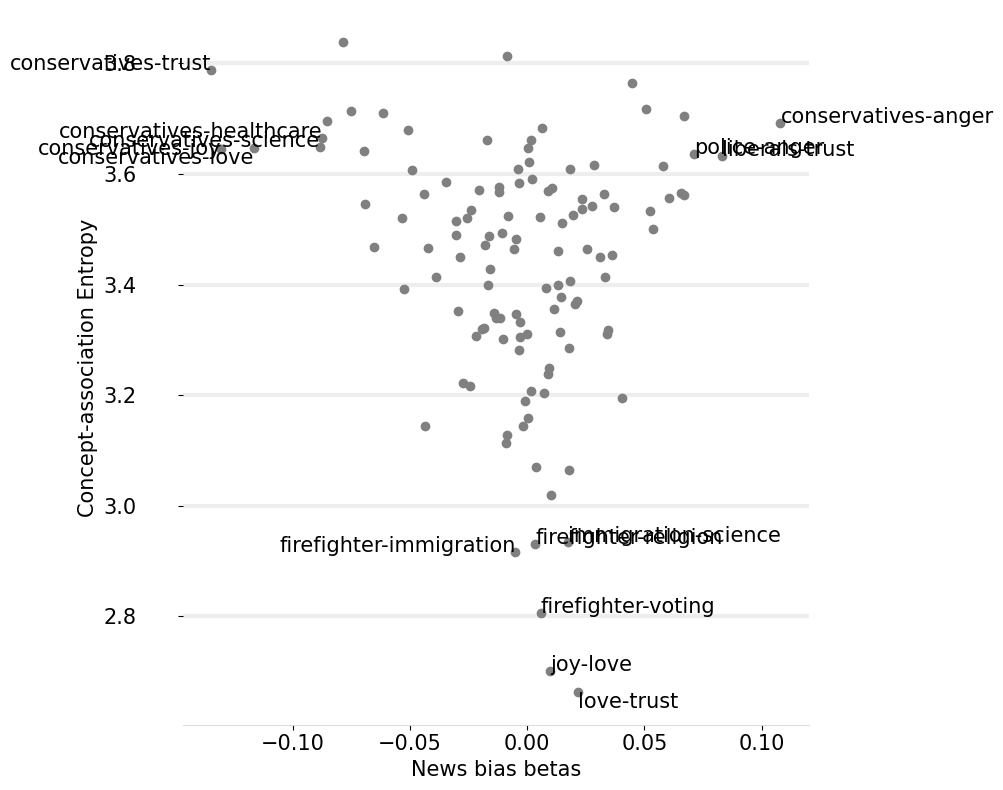

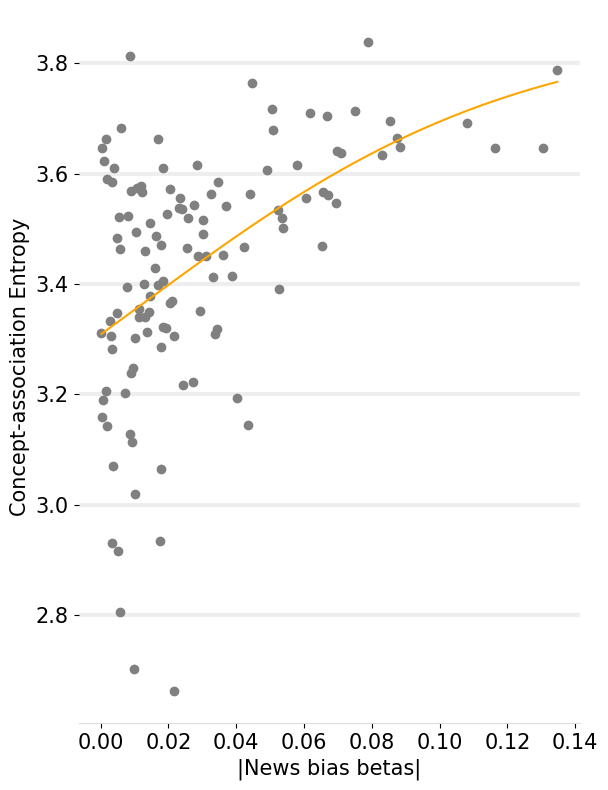

In [ ]:
# @title Figure 4: Edge entropy and news betas

#News predicting individal concept-pair edges
newsBetas = bObsPairsPRaM['5']

newsBetasAbs = np.absolute(newsBetas)
#Similarity data
PrAM_finalSim = PrAM_finalSim #cocnept-pairs in similarity space

#Shannon's entropy
base = 2  # work in units of bits

pairEntropy = []
for p in tqdm(range(len(PairLabel))):
  pairCounts = Counter(PrAM_finalSim[p])
  prop = []
  for c in pairCounts:
    propc = pairCounts[c]/PrAM_finalSim.shape[0]
    prop.append(propc)
  pk = prop
  H = entropy(pk, base=base)
  pairEntropy.append(H)

#Generate the line of best fit
import numpy, scipy, matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution

newsBetasAbs = np.absolute(newsBetas)

xData = numpy.array(newsBetasAbs)
yData = numpy.array(pairEntropy)

# generate initial parameter values
geneticParameters = generate_Initial_Parameters()

# curve fit the test data
fittedParameters, pcov = curve_fit(func, xData, yData, geneticParameters)

print('Parameters', fittedParameters)

modelPredictions = func(xData, *fittedParameters)

absError = modelPredictions - yData

#Compute parameterwise CI
from scipy.stats import t
n = len(yData) #data points
p = len(fittedParameters) #number of parameters
alpha = 0.05

dof = max(0,n-p) #degrees of freedom
tval = t.ppf(1.0-alpha/2.,dof)
SE=[]
pint=[]
for i, p, var in zip(range(n), fittedParameters, np.diag(pcov)):
  sigma = var**0.5
  SE.append(sigma)
  pint.append([p-sigma*tval, p+sigma*tval])
print('CI:',pint)

#Report RMSE and Rsquard
SE = numpy.square(absError) # squared errors
MSE = numpy.mean(SE) # mean squared errors
RMSE = numpy.sqrt(MSE) # Root Mean Squared Error, RMSE
Rsquared = 1.0 - (numpy.var(absError) / numpy.var(yData))
print('RMSE:', RMSE)
print('R-squared:', Rsquared)


#Generate Entropy Plots
#Threshold for labeling
bsd = np.std(newsBetas)
bmean = np.mean(newsBetas)
Thrbu = bmean + (1.8*bsd)
Thrbl = bmean - (2*bsd)
ThrMaskb = (newsBetas > Thrbu) | (newsBetas < Thrbl)

Hsd = np.std(pairEntropy)
Hmean = np.mean(pairEntropy)
ThrHu = Hmean + (1.9*Hsd)
ThrHl = Hmean - (1.9*Hsd)
ThrMaskH = (pairEntropy > ThrHu) | (pairEntropy < ThrHl)

combinedMask = ThrMaskb | ThrMaskH

pairLabelsScatter = []
for p in tqdm(range(len(PairLabel))):
  if combinedMask[p] == True:
    pairLabelsScatter.append(PairLabel[0][p])
  elif combinedMask[p] == False:
    pairLabelsScatter.append('')



#Plot Scatter plots
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.scatter(newsBetas, pairEntropy, c ='grey')
plt.xlabel("News bias betas", size=15)
plt.ylabel("Concept-association Entropy", size=15)

##add point labels
pairLabelsScatter_trim = [re.sub("[\(].*?[\)]", "", lab) for lab in pairLabelsScatter]
for i, txt in enumerate(pairLabelsScatter_trim):
  if (newsBetas[i] <= 0 and txt=='conservatives-love'):
    ax.annotate(txt, (newsBetas[i], pairEntropy[i]), va='top', ha='right', size=15)
  elif (newsBetas[i] <= 0 and txt=='conservatives-joy'):
    ax.annotate(txt, (newsBetas[i], pairEntropy[i]), va='center', ha='right', size=15)
  elif (newsBetas[i] <= 0 and txt=='liberals-anger'):
    ax.annotate(txt, (newsBetas[i], pairEntropy[i]), va='center', ha='right', size=15)
  elif (newsBetas[i] >= 0 and txt=='liberals-love'):
    ax.annotate(txt, (newsBetas[i], pairEntropy[i]), va='top', size=15)
  elif (newsBetas[i] >= 0 and txt=='love-trust'):
    ax.annotate(txt, (newsBetas[i], pairEntropy[i]), va='top', size=15)
  elif newsBetas[i] >= 0:
    ax.annotate(txt, (newsBetas[i], pairEntropy[i]), size=15)
  elif newsBetas[i] < 0:
    ax.annotate(txt, (newsBetas[i], pairEntropy[i]), ha='right', size=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE', linewidth=3)
ax.xaxis.grid(False)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', pad=30)
plt.show()


#Plot absolute value plot
fig = plt.figure(figsize=(6,8))
ax = fig.add_subplot(111)
plt.scatter(newsBetasAbs,pairEntropy, c ='grey')
plt.xlabel("|News bias betas|", size=15)
plt.ylabel("Concept-association Entropy", size=15)
# for i, txt in enumerate(pairLabelsScatter):
#   ax.annotate(txt, (newsBetasAbs[i], pairEntropy[i]))

#plt.annotate("R2 = {:.3f}".format(Rsquared), (0.06, 3.85), size=15)

# now the model as a line plot
xModel = numpy.linspace(min(xData), max(xData))
yModel = func(xModel, *fittedParameters)
ax.plot(xModel, yModel, color='orange')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE', linewidth=3)
ax.xaxis.grid(False)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

100%|██████████| 120/120 [00:00<00:00, 99844.57it/s]


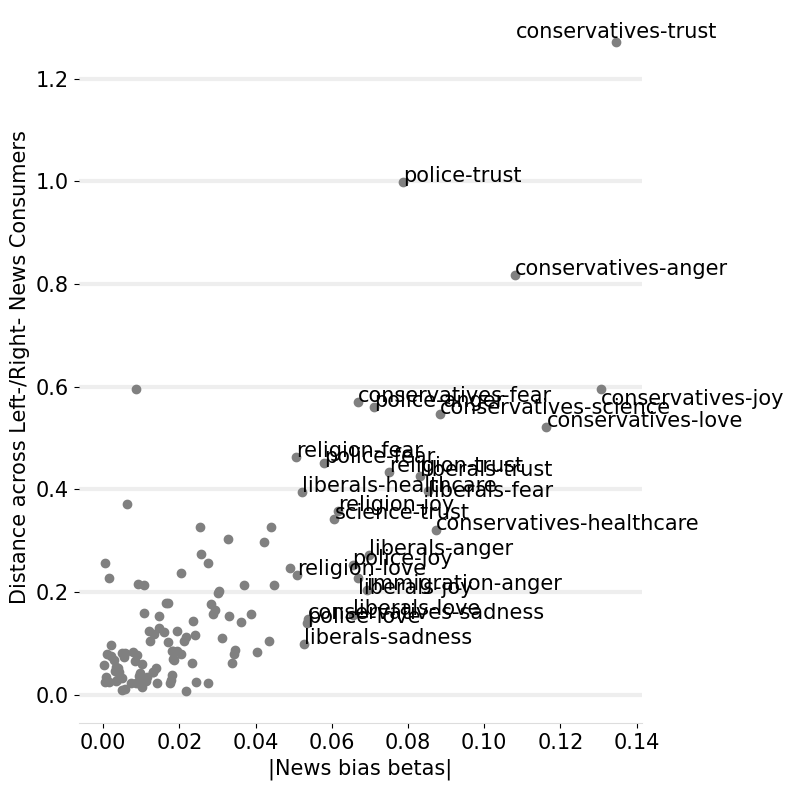

In [ ]:
# @title Representational distance by news bias effect (SI)
pairR = []

for p in tqdm(range(len(PairLabel))):
  lf = Counter(lfPRaM[p])
  rt = Counter(rtPRaM[p])

  tabulateRating = pd.DataFrame({'-7':[],'-6':[], '-5':[], '-4':[], '-3':[], '-2':[], '-1':[], '0':[], '1':[], '2':[], '3':[], '4':[], '5':[], '6':[], '7':[]})
  tabulateRating.loc[len(tabulateRating.index)] = [lf[-7], lf[-6], lf[-5], lf[-4], lf[-3], lf[-2], lf[-1], lf[0], lf[1], lf[2], lf[3], lf[4], lf[5], lf[6], lf[7]]
  tabulateRating.loc[len(tabulateRating.index)] = [rt[-7], rt[-6], rt[-5], rt[-4], rt[-3], rt[-2], rt[-1], rt[0], rt[1], rt[2], rt[3], rt[4], rt[5], rt[6], rt[7]]
  input = tabulateRating.transpose()
  r = np.corrcoef(input[0],input[1])
  pairR.append(1-r[0][1])

#Plot absolute value plot
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plt.scatter(newsBetasAbs,pairR, c ='grey')
plt.xlabel("|News bias betas|", size=15)
plt.ylabel("Distance across Left-/Right- News Consumers", size=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE', linewidth=3)
ax.xaxis.grid(False)
ax.tick_params(axis='both', which='major', labelsize=15)



#Threshold for labeling
bsd = np.std(newsBetas)
bmean = np.mean(newsBetas)
Thrbu = bmean + (1.8*bsd)
Thrbl = bmean - (2*bsd)
ThrMaskb = (newsBetas > Thrbu) | (newsBetas < Thrbl)

Hsd = np.std(pairR)
Hmean = np.mean(pairR)
ThrHu = Hmean + (1.9*Hsd)
ThrHl = Hmean - (1.9*Hsd)
ThrMaskH = (pairR > ThrHu) | (pairR < ThrHl)

combinedMask = ThrMaskb | ThrMaskH
combinedMask = (np.array(pairR) > 0.6) | (np.array(newsBetasAbs) > 0.05)

pairLabelsScatter = []
for p in tqdm(range(len(PairLabel))):
  if combinedMask[p] == True:
    pairLabelsScatter.append(PairLabel[0][p])
  elif combinedMask[p] == False:
    pairLabelsScatter.append('')

#trim parantheses
pairLabelsScatter_trim = [re.sub("[\(].*?[\)]", "", lab) for lab in pairLabelsScatter]

for i, txt in enumerate(pairLabelsScatter_trim):
  if (pairR[i] >= 0 and txt=='conservatives-joy'):
    ax.annotate(txt, (newsBetasAbs[i], pairR[i]), va='top', ha='left', size=15)
  elif (pairR[i] >= 0 and txt=='liberals-joy'):
    ax.annotate(txt, (newsBetasAbs[i], pairR[i]), va='top', ha='left', size=15)
  elif (pairR[i] >= 0 and txt=='liberals-fear'):
    ax.annotate(txt, (newsBetasAbs[i], pairR[i]), va='center', ha='left', size=15)
  elif (pairR[i] >= 0 and txt=='conservatives-immigration'):
    ax.annotate(txt, (newsBetasAbs[i], pairR[i]), va='center', ha='left', size=15)
  elif (pairR[i] >= 0 and txt=='conservatives-trust'):
    ax.annotate(txt, (newsBetasAbs[i], pairR[i]), va='bottom', ha='center', size=15)
  elif pairR[i] >= 0.6:
    ax.annotate(txt, (newsBetasAbs[i], pairR[i]), size=15)
  elif newsBetasAbs[i] > 0.05:
    ax.annotate(txt, (newsBetasAbs[i], pairR[i]), size=15) #, ha='right'
plt.show()